# Survey Property maps

Notebook to:
- Convert DECASU Survey Property maps to a suitable format to apply deprojection within the TXPipe pipeline
- Save at different resolutions, nside = 512 and 2048
- Organize

## Conversion
Script to convert from Healsparse to Healpix the observing conditions maps and also to degrade the resolution, from $n_{side} = 16384$ to $2048$ in order to be ingested in TXPipe and create the final data vector considering deprojection.

In [2]:
import healpy as hp
import sys
sys.path.insert(0, '/global/homes/d/davidsan/healsparse')
import healsparse as hsp
import os
from astropy.io import fits
import numpy as np

In [2]:
path_to_read = '/global/cfs/projectdirs/lsst/groups/LSS/HSC_data/decasu_maps'

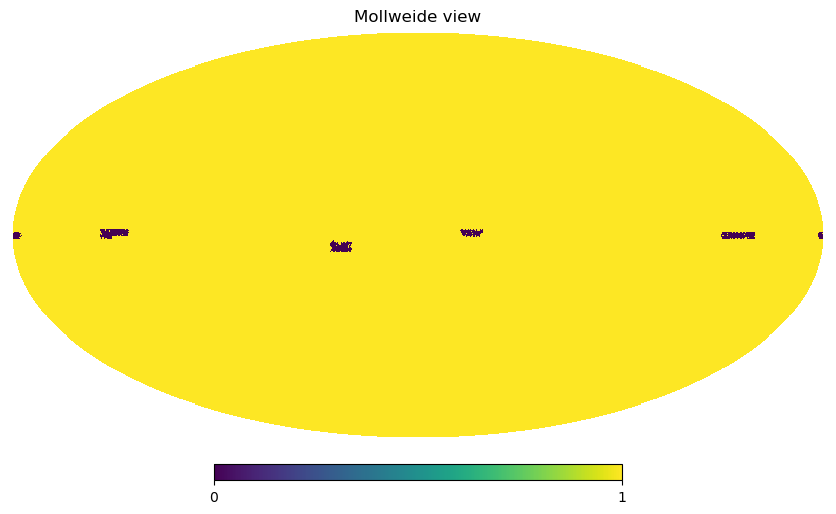

In [3]:
# Apply mask
fname_mask = '/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/mask/masked_fraction_nside4096_gama09hcorr_nohectomap.hs'
mask = hsp.HealSparseMap.read(fname_mask).generate_healpix_map(nside=2048, nest=False)
mask = np.where(mask != hp.UNSEEN, 0, 1)
hp.mollview(mask)

In [5]:
apply_mask = False

for nside in np.array([512, 2048]):
    print(f'>> Working with SP maps at nside = {nside}')
    # Apply mask
    fname_mask = '/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/mask/masked_fraction_nside4096_gama09hcorr_nohectomap.hs'
    if apply_mask == True:
        print('>> Applying mask')
        mask = hsp.HealSparseMap.read(fname).generate_healpix_map(nside=2048, nest=False)
        mask = np.where(mask != hp.UNSEEN, 0, 1)
    path_to_save = f'/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_{nside}'
    if not os.path.exists(path_to_save):
        os.makedirs(path_to_save)
        print(f"Path '{path_to_save}' created successfully.")
    else:
        print(f"Path '{path_to_save}' already exists.")
    for file in os.listdir(path_to_read):
        if file.startswith("s16a"):
            print('Reading map and converting: ', file)
            fname = os.path.join(path_to_read, file)
            hsp_map = hsp.HealSparseMap.read(fname).generate_healpix_map(nside=nside, nest=False)
            # Apply mask
            if apply_mask == True:
                hsp_map[mask] = hp.UNSEEN
            print("Saving as healpix map...")
            hdu = fits.PrimaryHDU(hsp_map)
            hdu.writeto(os.path.join(path_to_save, file[:-2]+'fits'), overwrite=True)

>> Working with SP maps at nside = 512
Path '/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512' already exists.
Reading map and converting:  s16a_wide_v3_g_maglim_wmean.hs
Saving as healpix map...
Reading map and converting:  s16a_wide_v3_i_airmass_wmean.hs
Saving as healpix map...
Reading map and converting:  s16a_wide_v3_g_exptime_sum.hs
Saving as healpix map...
Reading map and converting:  s16a_wide_v3_g_dcr_e1_wmean.hs
Saving as healpix map...
Reading map and converting:  s16a_wide_v3_r_dcr_e1_wmean.hs
Saving as healpix map...
Reading map and converting:  s16a_wide_v3_y_dcr_ddec_wmean.hs
Saving as healpix map...
Reading map and converting:  s16a_wide_v3_r_nexp_sum.hs
Saving as healpix map...
Reading map and converting:  s16a_wide_v3_r_airmass_wmean.hs
Saving as healpix map...
Reading map and converting:  s16a_wide_v3_i_dcr_dra_wmean.hs
Saving as healpix map...
Reading map and converting:  s16a_wide_v3_r_dcr_ddec_wmean.hs
Saving as healpix map...

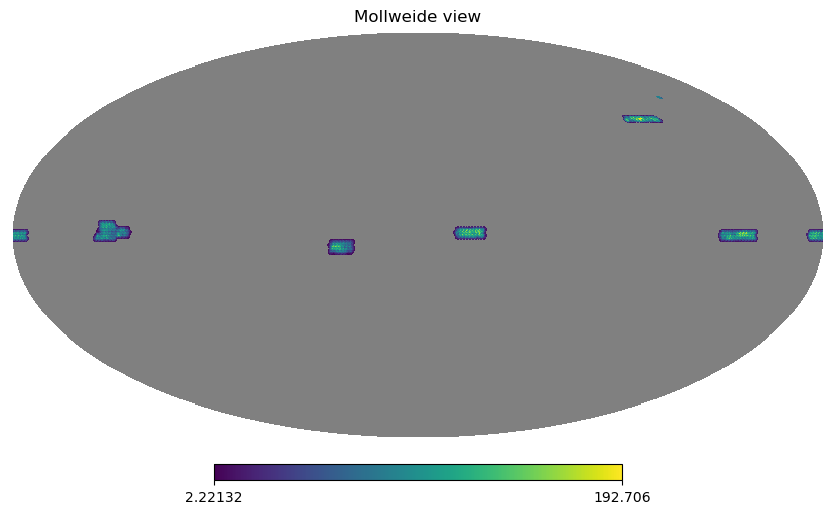

In [6]:
hp.mollview(hsp_map)

### CMB maps

Thermal Sunyaev-Zeldovich map

In [7]:
path = "/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/"
path_syst = os.path.join(path, 'systematics_maps/maps_2048')
path_syst_save_512 = os.path.join(path, 'systematics_maps/cmb_maps_512')
path_syst_save_2048 = os.path.join(path, 'systematics_maps/cmb_maps_2048')

In [8]:
# Generate mask, where to consider CMB info
fname_syst = os.listdir(path_syst)[0]
syst_map = fits.open(os.path.join(path_syst, fname_syst))[0].data
mask = np.where(syst_map != hp.UNSEEN)[0]

#### thermal Sunyaev-Zeldovich

In [9]:
from astropy.table import Table

In [10]:
fname_tsz = os.path.join('/pscratch/sd/d/davidsan/3x2pt-HSC/thermalSZ/COM_CompMap_Compton-SZMap-nilc-ymaps_2048_R2.00.fits')
table = Table.read(fname_tsz)
full_ymap_2048 = np.array(table['FULL'])

# nside = 2048
full_ymap_2048_mask = np.ones(12*2048**2) * hp.UNSEEN
full_ymap_2048_mask[mask] = full_ymap_2048[mask]
hp.write_map(os.path.join(path_syst_save_2048, 'tSZ_nside_2048.fits'), full_ymap_2048_mask, nest=False, overwrite=True)

# Degrading to nside = 512
full_ymap_512_mask = hp.pixelfunc.ud_grade(map_in = full_ymap_2048_mask, nside_out = 512)
hp.write_map(os.path.join(path_syst_save_512, 'tSZ_nside_512.fits'), full_ymap_512_mask, nest=False, overwrite=True)

setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


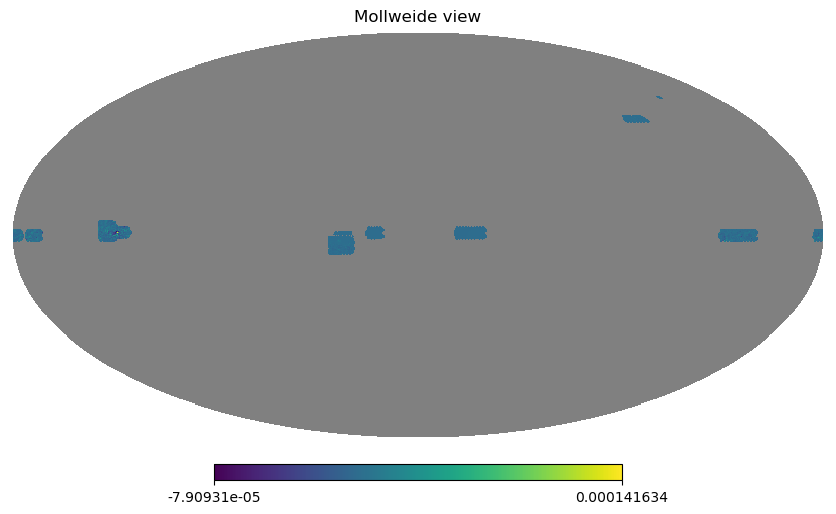

In [11]:
hp.mollview(full_ymap_2048_mask)

#### CMB Lensing (CMB $\kappa$)

In [12]:
fname_kappa = os.path.join('/pscratch/sd/d/davidsan/3x2pt-HSC/CMBKappa/COM_CompMap_Lensing_2048_R1.10.fits')
table = Table.read(fname_kappa, hdu=1)
# CMB Lensing map
kappa = table['PHIBAR']
# Converting from NEST to RING ordering
kappa = hp.pixelfunc.reorder(map_in=kappa, n2r=True)

kappa_2048 = np.ones(12*2048**2) * hp.UNSEEN
kappa_2048[mask] = kappa[mask]
hp.write_map(os.path.join(path_syst_save_2048, 'CMB_kappa_nside_2048.fits'), kappa_2048, nest=False, overwrite=True)

kappa_512 = hp.pixelfunc.ud_grade(map_in = kappa_2048, nside_out = 512)
hp.write_map(os.path.join(path_syst_save_512, 'CMB_kappa_nside_512.fits'), kappa_512, nest=False, overwrite=True)

setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


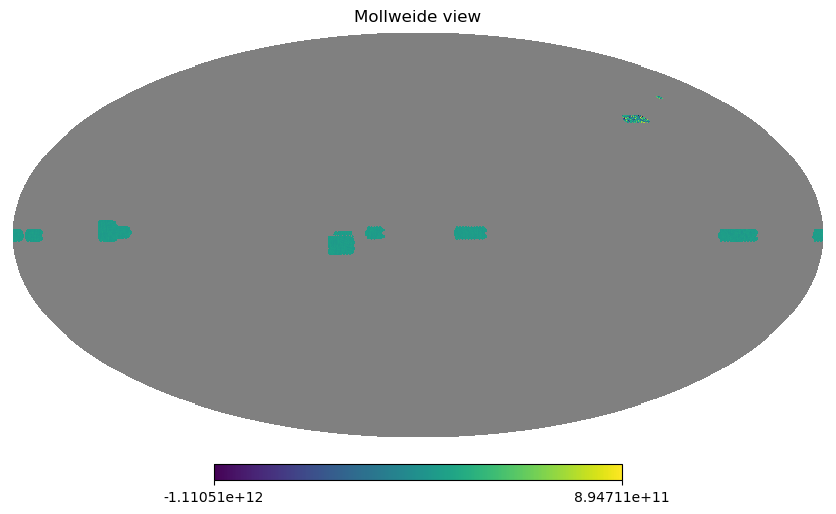

In [13]:
hp.mollview(kappa_2048)

## Normalize SP maps

In [4]:
from tqdm import tqdm
import h5py
import os
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

##### Scalars

Normalizing SP maps at nside = 512
Path '/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/tensors/normalized' already exists.
/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/tensors


  0%|          | 0/11 [00:00<?, ?it/s]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/tensors/s16a_wide_v3_y_dcr_e1_wmean.fits
Reading  s16a_wide_v3_y_dcr_e1_wmean.fits
Masking table...


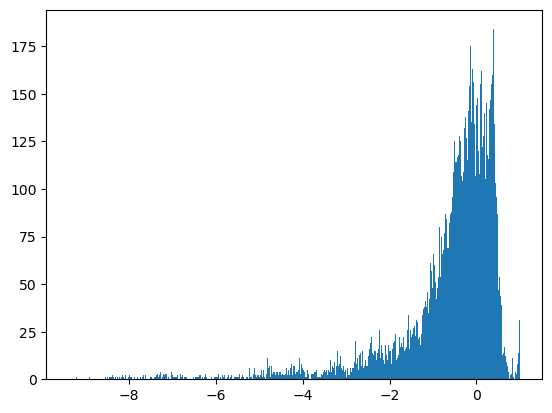

setting the output map dtype to [dtype('>f8')]
  9%|▉         | 1/11 [00:01<00:16,  1.68s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/tensors/s16a_wide_v3_i_dcr_e1_wmean.fits
Reading  s16a_wide_v3_i_dcr_e1_wmean.fits
Masking table...


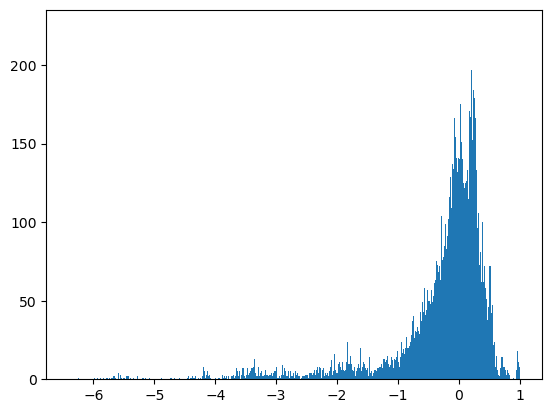

setting the output map dtype to [dtype('>f8')]
 18%|█▊        | 2/11 [00:03<00:14,  1.65s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/tensors/s16a_wide_v3_r_dcr_e2_wmean.fits
Reading  s16a_wide_v3_r_dcr_e2_wmean.fits
Masking table...


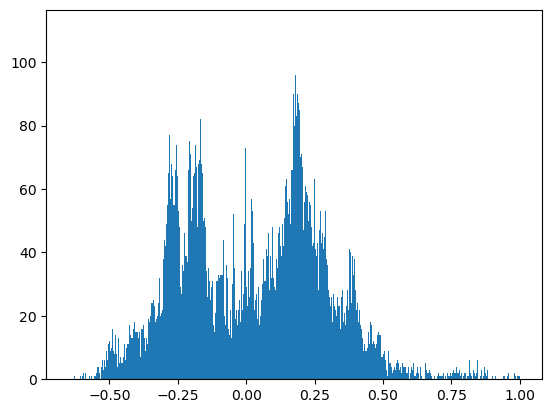

setting the output map dtype to [dtype('>f8')]
 27%|██▋       | 3/11 [00:05<00:13,  1.69s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/tensors/s16a_wide_v3_g_dcr_e1_wmean.fits
Reading  s16a_wide_v3_g_dcr_e1_wmean.fits
Masking table...


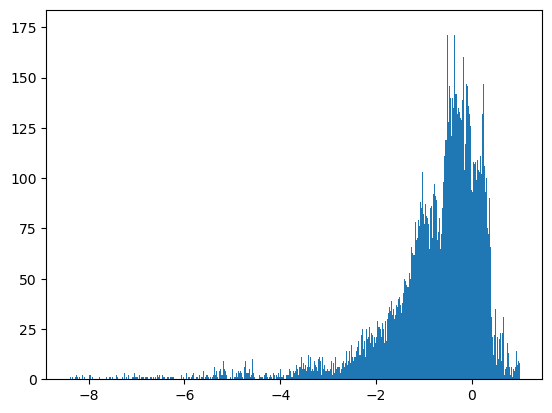

setting the output map dtype to [dtype('>f8')]
 45%|████▌     | 5/11 [00:06<00:07,  1.20s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/tensors/s16a_wide_v3_z_dcr_e2_wmean.fits
Reading  s16a_wide_v3_z_dcr_e2_wmean.fits
Masking table...


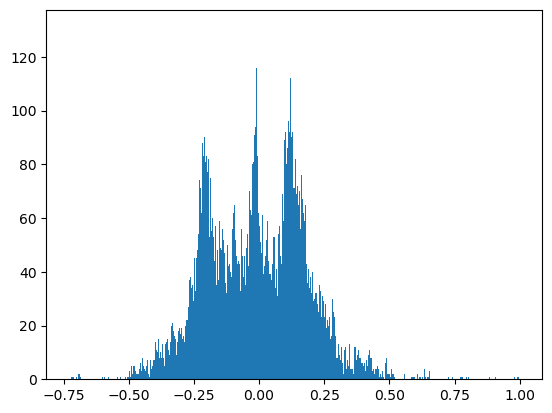

setting the output map dtype to [dtype('>f8')]
 55%|█████▍    | 6/11 [00:08<00:06,  1.31s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/tensors/s16a_wide_v3_i_dcr_e2_wmean.fits
Reading  s16a_wide_v3_i_dcr_e2_wmean.fits
Masking table...


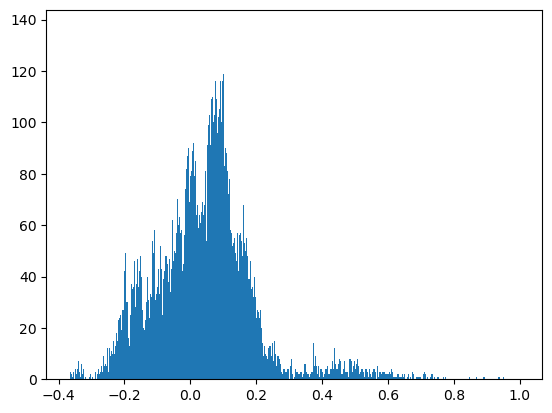

setting the output map dtype to [dtype('>f8')]
 64%|██████▎   | 7/11 [00:09<00:05,  1.41s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/tensors/s16a_wide_v3_r_dcr_e1_wmean.fits
Reading  s16a_wide_v3_r_dcr_e1_wmean.fits
Masking table...


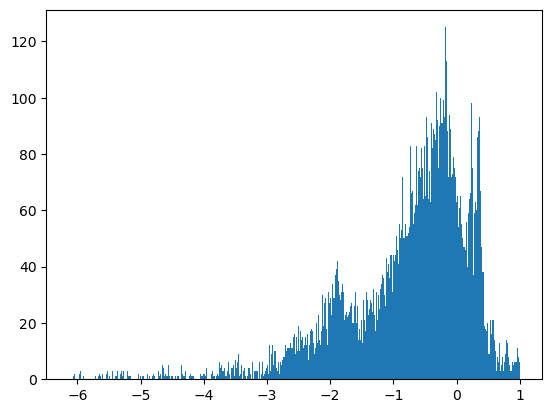

setting the output map dtype to [dtype('>f8')]
 73%|███████▎  | 8/11 [00:11<00:04,  1.49s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/tensors/s16a_wide_v3_y_dcr_e2_wmean.fits
Reading  s16a_wide_v3_y_dcr_e2_wmean.fits
Masking table...


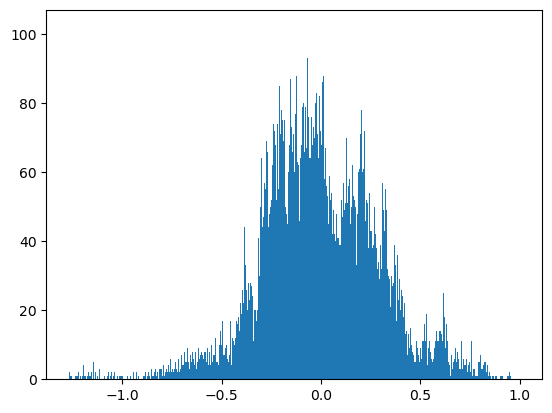

setting the output map dtype to [dtype('>f8')]
 82%|████████▏ | 9/11 [00:13<00:03,  1.52s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/tensors/s16a_wide_v3_z_dcr_e1_wmean.fits
Reading  s16a_wide_v3_z_dcr_e1_wmean.fits
Masking table...


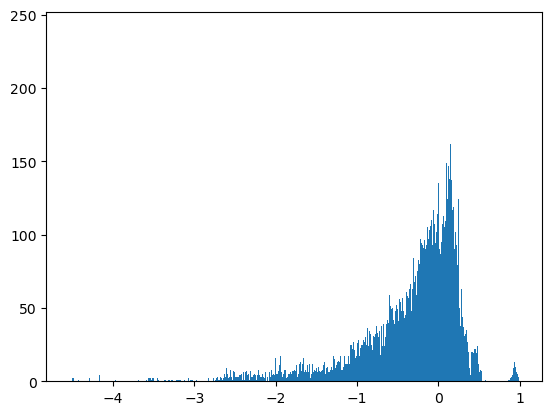

setting the output map dtype to [dtype('>f8')]
 91%|█████████ | 10/11 [00:14<00:01,  1.54s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/tensors/s16a_wide_v3_g_dcr_e2_wmean.fits
Reading  s16a_wide_v3_g_dcr_e2_wmean.fits
Masking table...


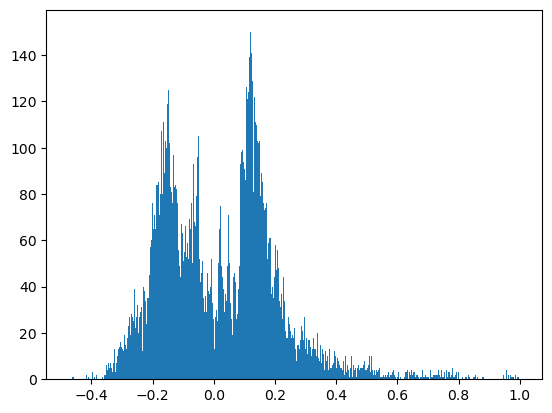

setting the output map dtype to [dtype('>f8')]
100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


Normalizing SP maps at nside = 2048
Path '/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/tensors/normalized' already exists.
/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/tensors


  0%|          | 0/12 [00:00<?, ?it/s]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/tensors/s16a_wide_v3_y_dcr_e1_wmean.fits
Reading  s16a_wide_v3_y_dcr_e1_wmean.fits
Masking table...


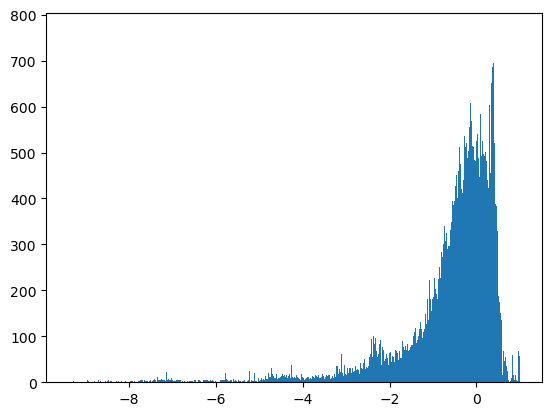

setting the output map dtype to [dtype('>f8')]
  8%|▊         | 1/12 [00:08<01:30,  8.21s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/tensors/s16a_wide_v3_i_dcr_e1_wmean.fits
Reading  s16a_wide_v3_i_dcr_e1_wmean.fits
Masking table...


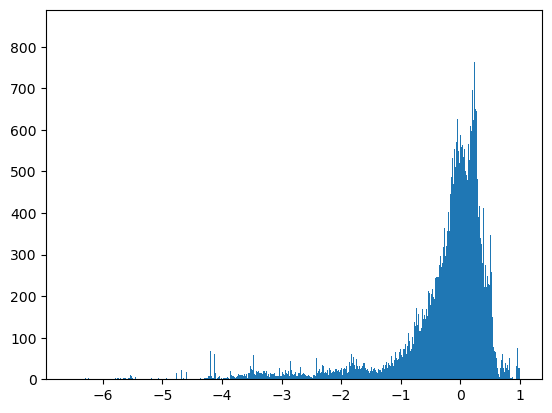

setting the output map dtype to [dtype('>f8')]
 17%|█▋        | 2/12 [00:15<01:19,  7.95s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/tensors/s16a_wide_v3_r_dcr_e2_wmean.fits
Reading  s16a_wide_v3_r_dcr_e2_wmean.fits
Masking table...


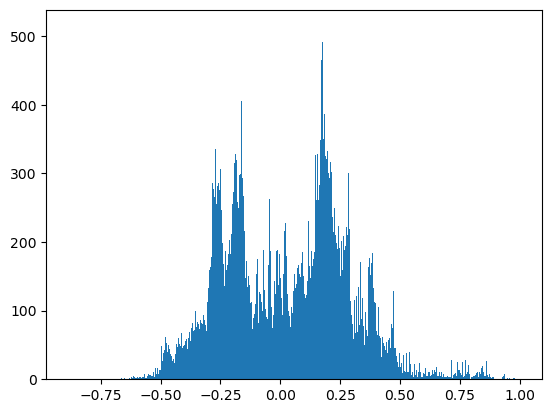

setting the output map dtype to [dtype('>f8')]
 25%|██▌       | 3/12 [00:23<01:09,  7.78s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/tensors/s16a_wide_v3_g_dcr_e1_wmean.fits
Reading  s16a_wide_v3_g_dcr_e1_wmean.fits
Masking table...


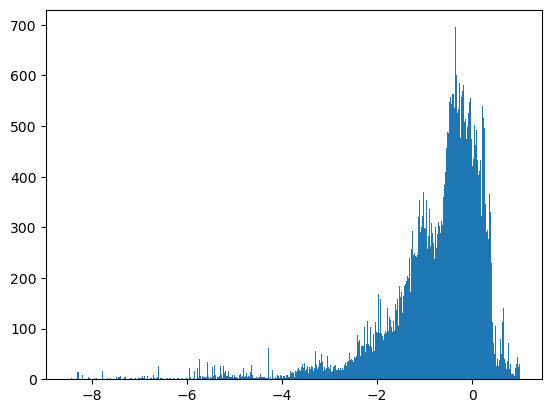

setting the output map dtype to [dtype('>f8')]
 42%|████▏     | 5/12 [00:31<00:39,  5.71s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/tensors/s16a_wide_v3_z_dcr_e2_wmean.fits
Reading  s16a_wide_v3_z_dcr_e2_wmean.fits
Masking table...


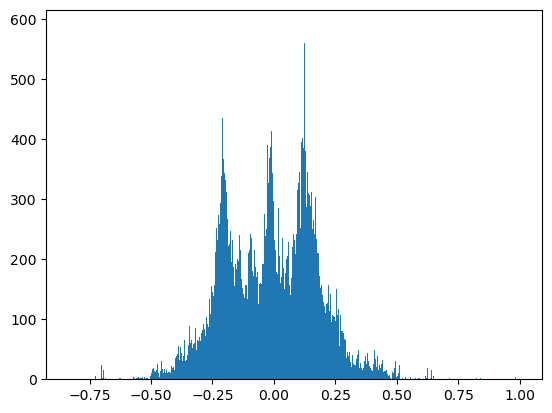

setting the output map dtype to [dtype('>f8')]
 50%|█████     | 6/12 [00:39<00:37,  6.32s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/tensors/s16a_wide_v3_i_dcr_e2_wmean.fits
Reading  s16a_wide_v3_i_dcr_e2_wmean.fits
Masking table...


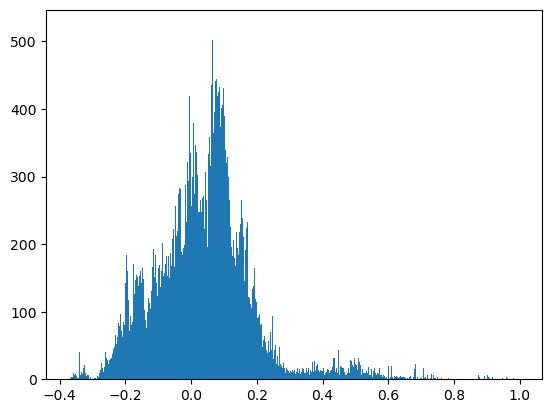

setting the output map dtype to [dtype('>f8')]
 67%|██████▋   | 8/12 [00:47<00:21,  5.35s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/tensors/s16a_wide_v3_r_dcr_e1_wmean.fits
Reading  s16a_wide_v3_r_dcr_e1_wmean.fits
Masking table...


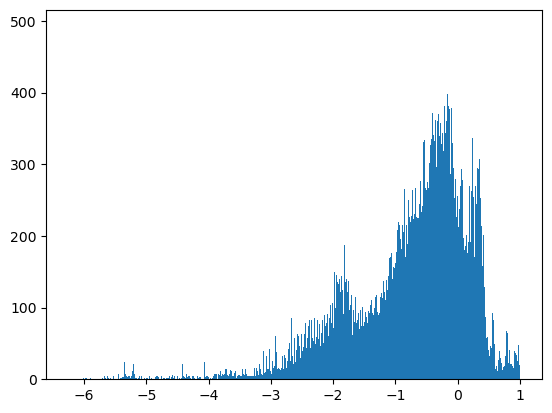

setting the output map dtype to [dtype('>f8')]
 75%|███████▌  | 9/12 [00:56<00:18,  6.16s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/tensors/s16a_wide_v3_y_dcr_e2_wmean.fits
Reading  s16a_wide_v3_y_dcr_e2_wmean.fits
Masking table...


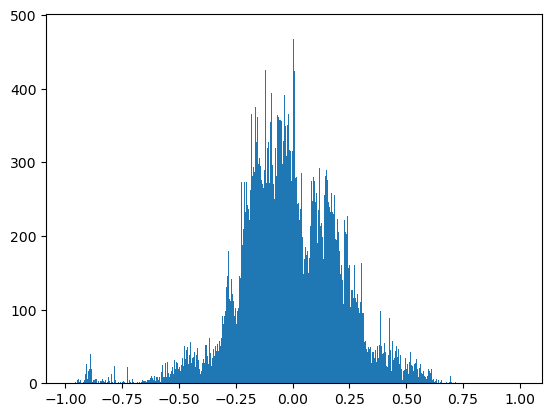

setting the output map dtype to [dtype('>f8')]
 83%|████████▎ | 10/12 [01:04<00:13,  6.58s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/tensors/s16a_wide_v3_z_dcr_e1_wmean.fits
Reading  s16a_wide_v3_z_dcr_e1_wmean.fits
Masking table...


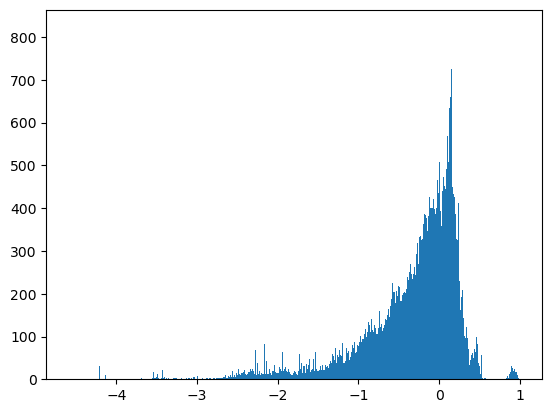

setting the output map dtype to [dtype('>f8')]
 92%|█████████▏| 11/12 [01:12<00:06,  6.91s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/tensors/s16a_wide_v3_g_dcr_e2_wmean.fits
Reading  s16a_wide_v3_g_dcr_e2_wmean.fits
Masking table...


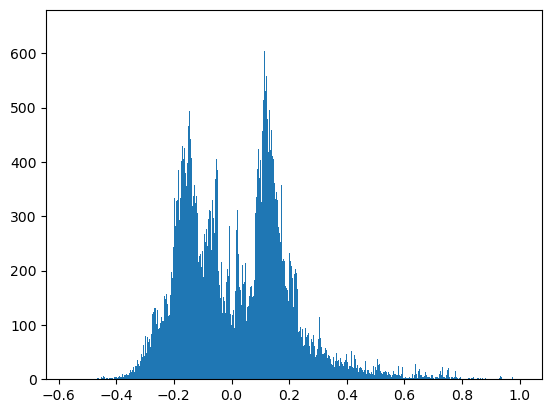

setting the output map dtype to [dtype('>f8')]
100%|██████████| 12/12 [01:20<00:00,  6.68s/it]


In [2]:
### Tensor maps
path_proj = "/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/"

for nside in np.array([512,2048]):
    print(f'Normalizing SP maps at nside = {nside}')
    # Just applying PCA to scalar maps
    if nside == 512:
        path_sys_maps = os.path.join(path_proj, "systematics_maps/maps_512/tensors")
    elif nside == 2048:
        path_sys_maps = os.path.join(path_proj, "systematics_maps/maps_2048/tensors")
    path_to_save = os.path.join(path_sys_maps, "normalized")
    if not os.path.exists(path_to_save):
        os.makedirs(path_to_save)
        print(f"Path '{path_to_save}' created successfully.")
    else:
        print(f"Path '{path_to_save}' already exists.")
    print(path_sys_maps)
    for map_name in tqdm(os.listdir(path_sys_maps)):
        if "s16a" in map_name:
            fname_sys = os.path.join(path_sys_maps, map_name)
            print(fname_sys)
            print('Reading ', map_name)
            with fits.open(fname_sys) as data:
                print('Masking table...')
                map_ = data[0].data

            # plt.hist(map_[map_ != hp.UNSEEN],bins=int(np.sqrt(len(map_))))
            # plt.show()

            # Normalization
            map_[map_ != hp.UNSEEN] /= max(map_[map_ != hp.UNSEEN])

            plt.hist(map_[map_ != hp.UNSEEN],bins=int(np.sqrt(len(map_))))
            plt.show()

            # Saving normalized maps
            hp.write_map(os.path.join(path_to_save, 'norm_'+map_name), map_, nest=False, overwrite=True)

##### Scalars

Normalizing SP maps at nside = 512
Path '/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/normalized' already exists.
/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars


  0%|          | 0/51 [00:00<?, ?it/s]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_r_weight_sum.fits
Reading  s16a_wide_v3_r_weight_sum.fits
Masking table...


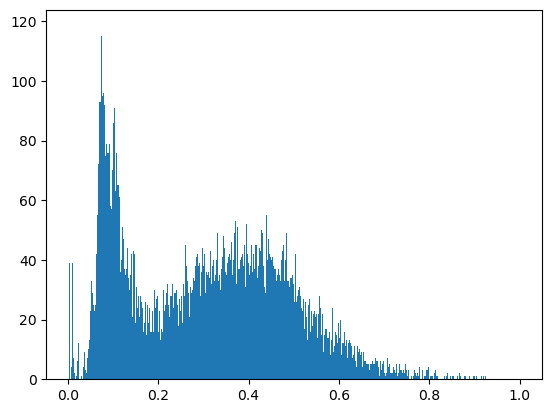

setting the output map dtype to [dtype('>f8')]
  2%|▏         | 1/51 [00:01<01:18,  1.56s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_g_maglim_wmean.fits
Reading  s16a_wide_v3_g_maglim_wmean.fits
Masking table...


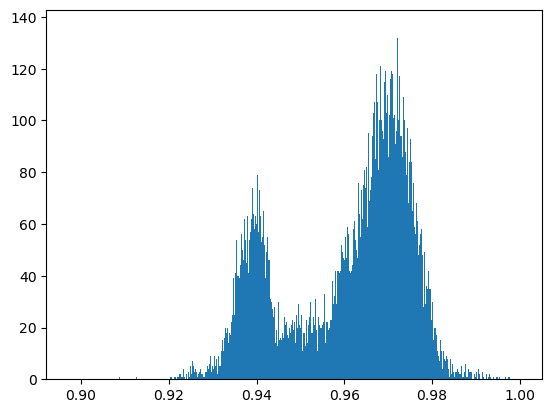

setting the output map dtype to [dtype('>f8')]
  4%|▍         | 2/51 [00:03<01:20,  1.63s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_g_sigma_sky_wmean.fits
Reading  s16a_wide_v3_g_sigma_sky_wmean.fits
Masking table...


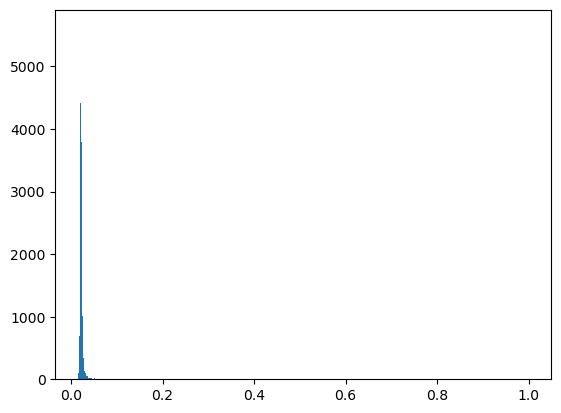

setting the output map dtype to [dtype('>f8')]
  6%|▌         | 3/51 [00:04<01:17,  1.62s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_z_dcr_dra_wmean.fits
Reading  s16a_wide_v3_z_dcr_dra_wmean.fits
Masking table...


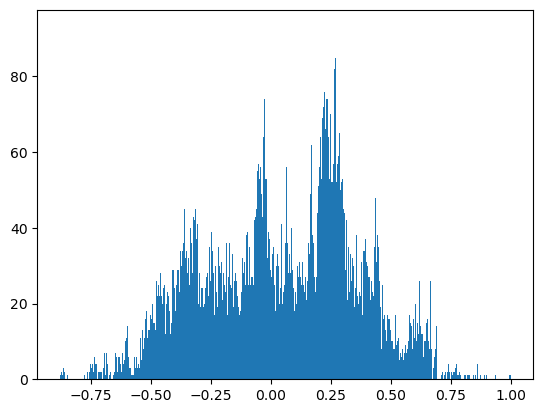

setting the output map dtype to [dtype('>f8')]
  8%|▊         | 4/51 [00:06<01:15,  1.61s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_g_exptime_sum.fits
Reading  s16a_wide_v3_g_exptime_sum.fits
Masking table...


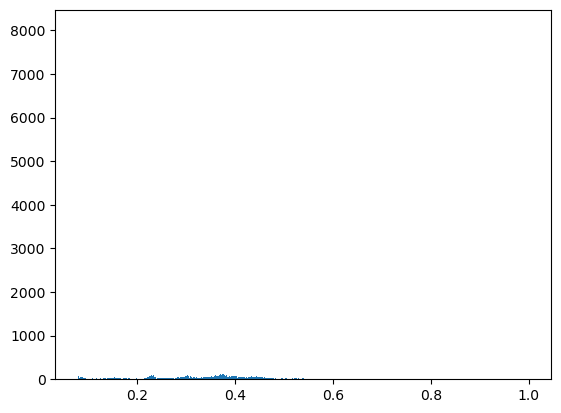

setting the output map dtype to [dtype('>f8')]
 10%|▉         | 5/51 [00:08<01:13,  1.60s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_y_sigma_sky_wmean.fits
Reading  s16a_wide_v3_y_sigma_sky_wmean.fits
Masking table...


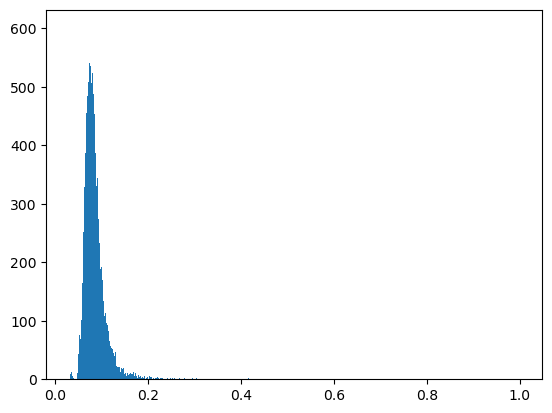

setting the output map dtype to [dtype('>f8')]
 12%|█▏        | 6/51 [00:09<01:12,  1.61s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_y_skylevel_wmean.fits
Reading  s16a_wide_v3_y_skylevel_wmean.fits
Masking table...


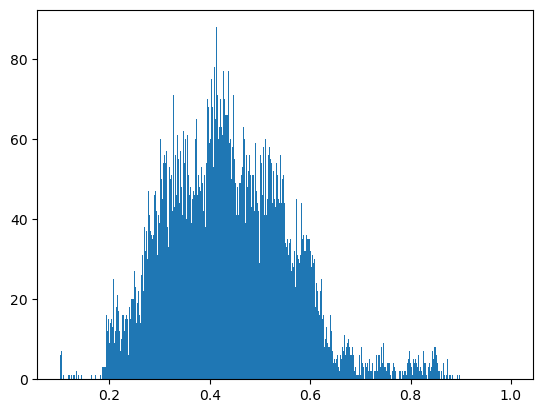

setting the output map dtype to [dtype('>f8')]
 14%|█▎        | 7/51 [00:11<01:12,  1.64s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_y_seeing_wmean.fits
Reading  s16a_wide_v3_y_seeing_wmean.fits
Masking table...


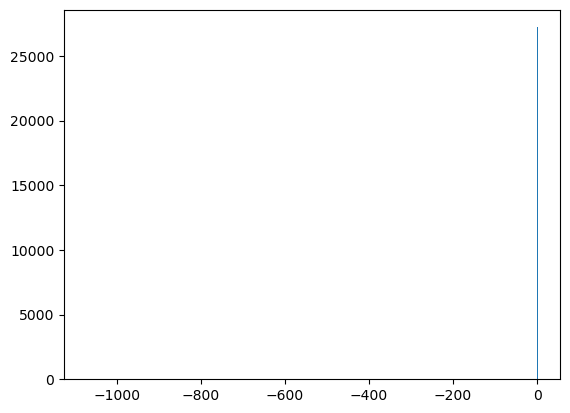

setting the output map dtype to [dtype('>f8')]
 16%|█▌        | 8/51 [00:12<01:09,  1.62s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_r_seeing_wmean.fits
Reading  s16a_wide_v3_r_seeing_wmean.fits
Masking table...


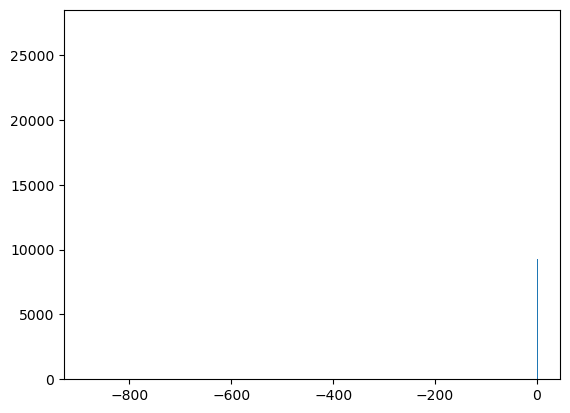

setting the output map dtype to [dtype('>f8')]
 18%|█▊        | 9/51 [00:14<01:07,  1.61s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_z_dcr_ddec_wmean.fits
Reading  s16a_wide_v3_z_dcr_ddec_wmean.fits
Masking table...


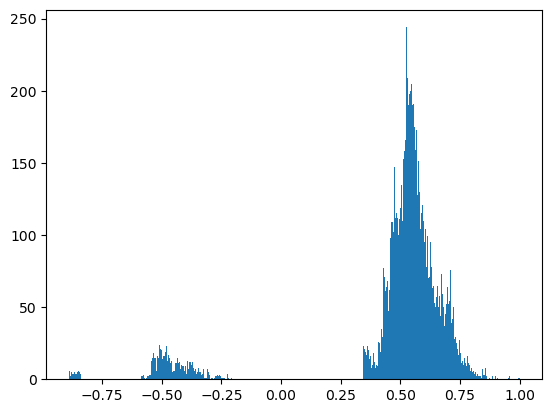

setting the output map dtype to [dtype('>f8')]
 20%|█▉        | 10/51 [00:16<01:05,  1.61s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_r_maglim_wmean.fits
Reading  s16a_wide_v3_r_maglim_wmean.fits
Masking table...


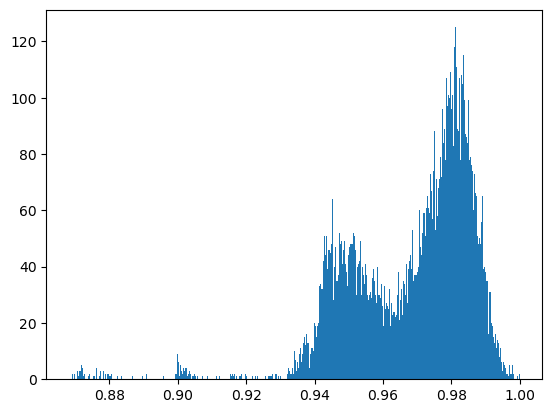

setting the output map dtype to [dtype('>f8')]
 22%|██▏       | 11/51 [00:17<01:04,  1.60s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_i_airmass_wmean.fits
Reading  s16a_wide_v3_i_airmass_wmean.fits
Masking table...


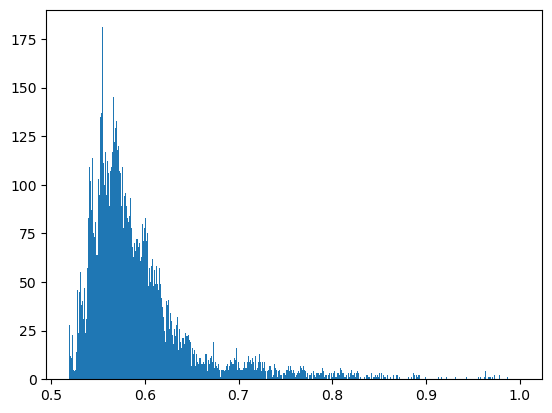

setting the output map dtype to [dtype('>f8')]
 25%|██▌       | 13/51 [00:19<00:47,  1.25s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_z_airmass_wmean.fits
Reading  s16a_wide_v3_z_airmass_wmean.fits
Masking table...


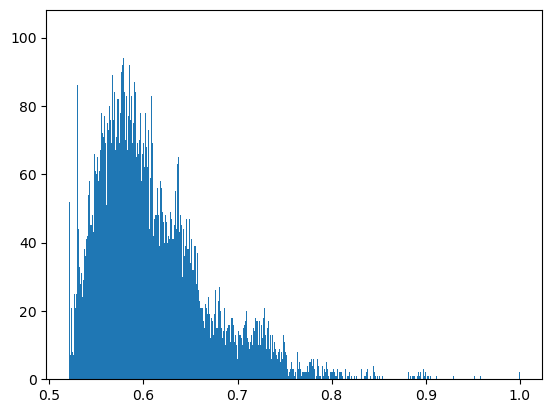

setting the output map dtype to [dtype('>f8')]
 27%|██▋       | 14/51 [00:21<00:49,  1.34s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_z_nexp_sum.fits
Reading  s16a_wide_v3_z_nexp_sum.fits
Masking table...


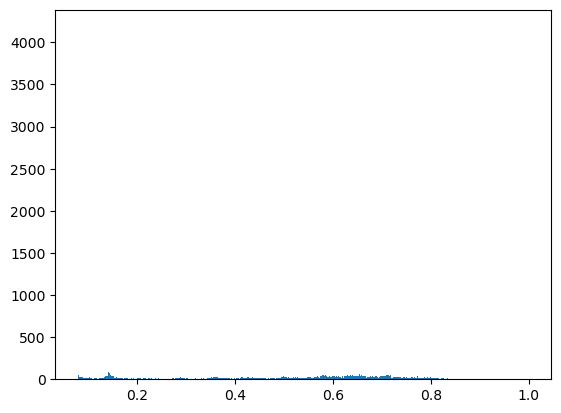

setting the output map dtype to [dtype('>f8')]
 29%|██▉       | 15/51 [00:22<00:51,  1.42s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_i_weight_sum.fits
Reading  s16a_wide_v3_i_weight_sum.fits
Masking table...


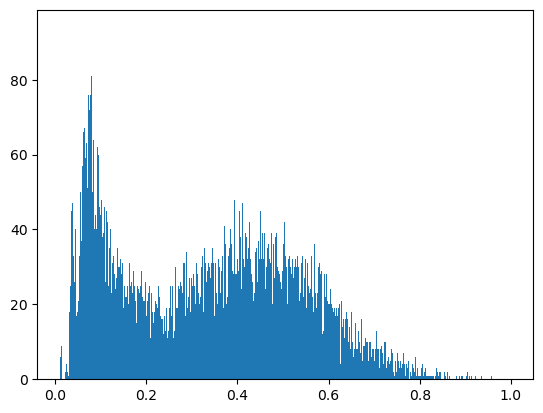

setting the output map dtype to [dtype('>f8')]
 31%|███▏      | 16/51 [00:24<00:51,  1.46s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_i_sigma_sky_wmean.fits
Reading  s16a_wide_v3_i_sigma_sky_wmean.fits
Masking table...


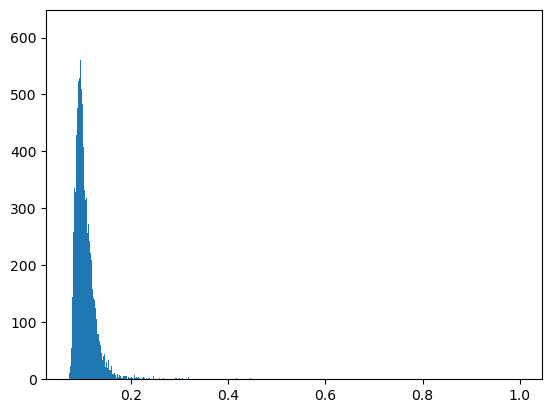

setting the output map dtype to [dtype('>f8')]
 33%|███▎      | 17/51 [00:25<00:51,  1.53s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_r_skylevel_wmean.fits
Reading  s16a_wide_v3_r_skylevel_wmean.fits
Masking table...


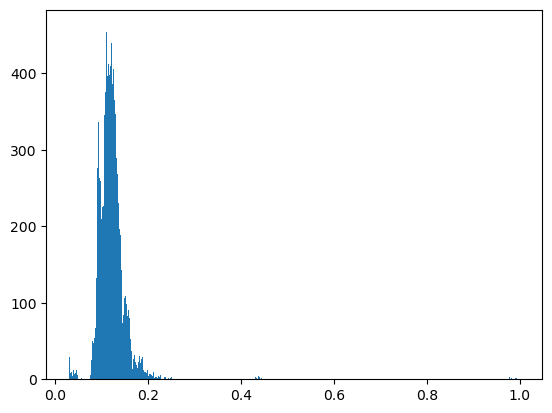

setting the output map dtype to [dtype('>f8')]
 35%|███▌      | 18/51 [00:27<00:51,  1.56s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_g_dcr_dra_wmean.fits
Reading  s16a_wide_v3_g_dcr_dra_wmean.fits
Masking table...


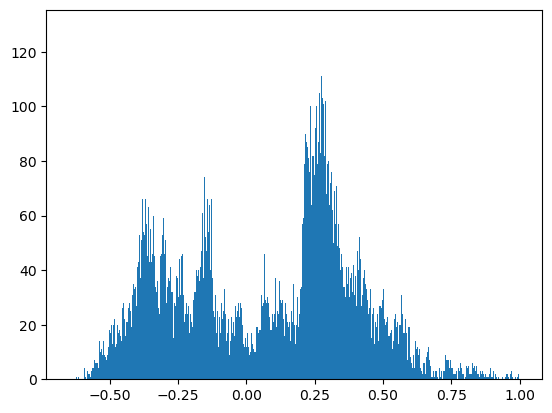

setting the output map dtype to [dtype('>f8')]
 37%|███▋      | 19/51 [00:29<00:50,  1.57s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_y_dcr_ddec_wmean.fits
Reading  s16a_wide_v3_y_dcr_ddec_wmean.fits
Masking table...


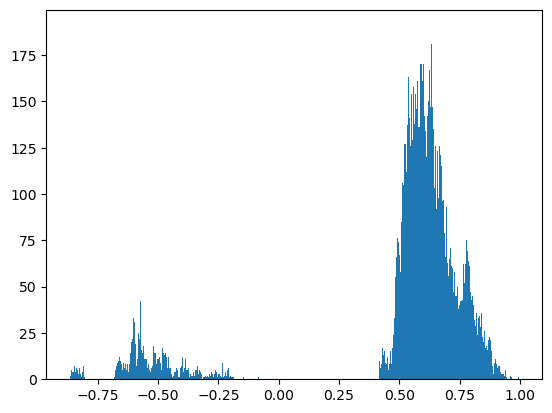

setting the output map dtype to [dtype('>f8')]
 39%|███▉      | 20/51 [00:30<00:49,  1.59s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_y_weight_sum.fits
Reading  s16a_wide_v3_y_weight_sum.fits
Masking table...


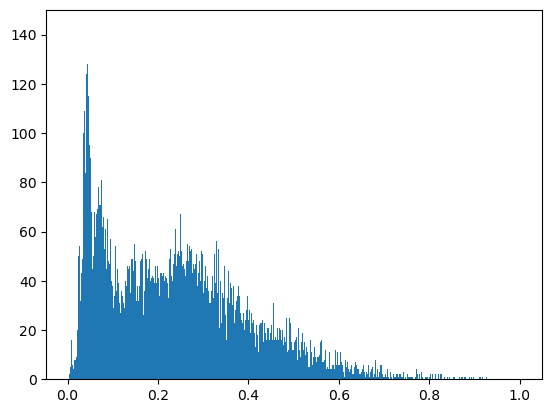

setting the output map dtype to [dtype('>f8')]
 41%|████      | 21/51 [00:32<00:47,  1.59s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_i_exptime_sum.fits
Reading  s16a_wide_v3_i_exptime_sum.fits
Masking table...


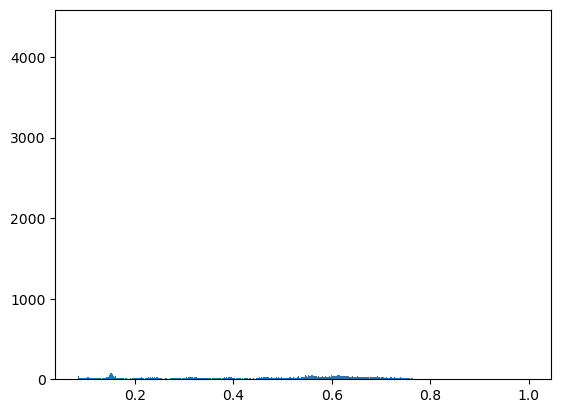

setting the output map dtype to [dtype('>f8')]
 43%|████▎     | 22/51 [00:34<00:46,  1.62s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_z_maglim_wmean.fits
Reading  s16a_wide_v3_z_maglim_wmean.fits
Masking table...


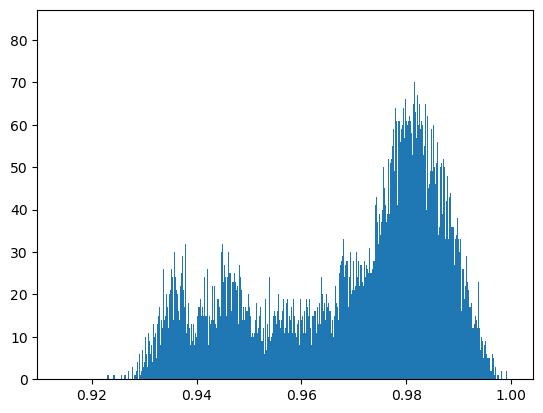

setting the output map dtype to [dtype('>f8')]
 45%|████▌     | 23/51 [00:35<00:45,  1.62s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_z_weight_sum.fits
Reading  s16a_wide_v3_z_weight_sum.fits
Masking table...


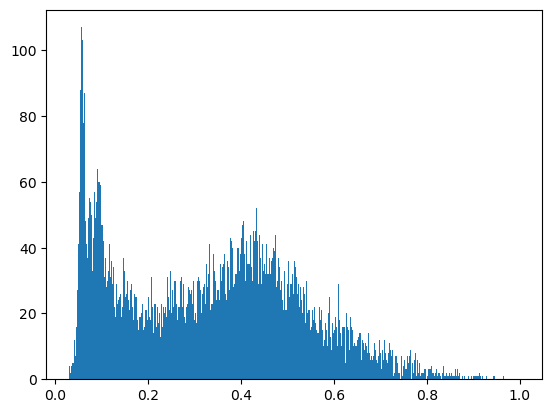

setting the output map dtype to [dtype('>f8')]
 47%|████▋     | 24/51 [00:37<00:43,  1.61s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_y_maglim_wmean.fits
Reading  s16a_wide_v3_y_maglim_wmean.fits
Masking table...


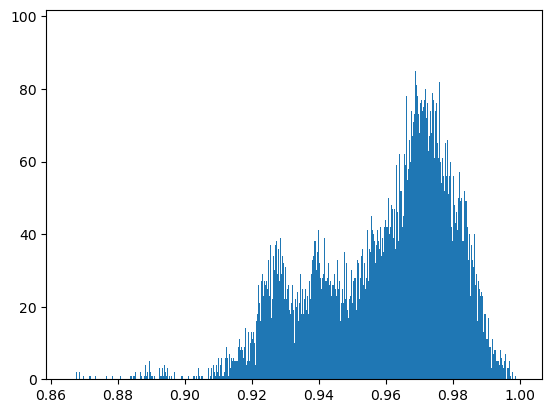

setting the output map dtype to [dtype('>f8')]
 49%|████▉     | 25/51 [00:38<00:42,  1.63s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_y_airmass_wmean.fits
Reading  s16a_wide_v3_y_airmass_wmean.fits
Masking table...


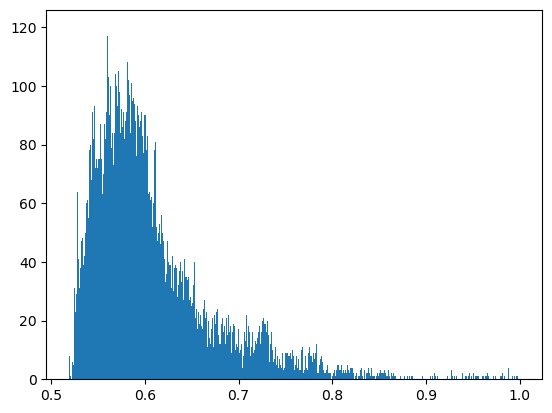

setting the output map dtype to [dtype('>f8')]
 51%|█████     | 26/51 [00:40<00:40,  1.62s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_i_seeing_wmean.fits
Reading  s16a_wide_v3_i_seeing_wmean.fits
Masking table...


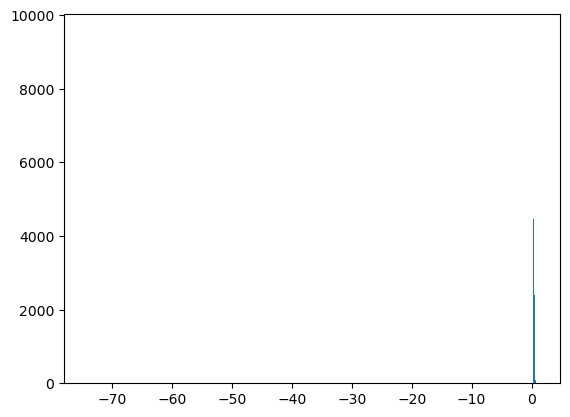

setting the output map dtype to [dtype('>f8')]
 53%|█████▎    | 27/51 [00:42<00:39,  1.64s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_g_seeing_wmean.fits
Reading  s16a_wide_v3_g_seeing_wmean.fits
Masking table...


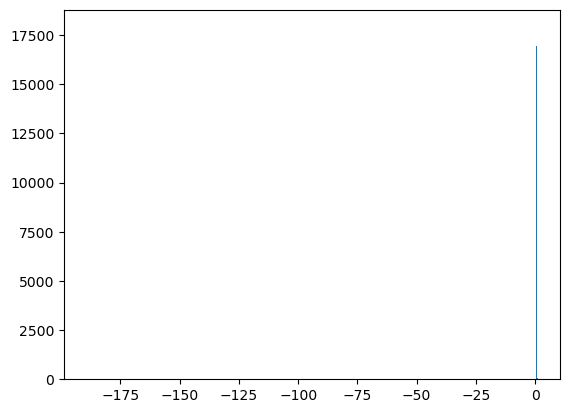

setting the output map dtype to [dtype('>f8')]
 55%|█████▍    | 28/51 [00:43<00:37,  1.64s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_r_nexp_sum.fits
Reading  s16a_wide_v3_r_nexp_sum.fits
Masking table...


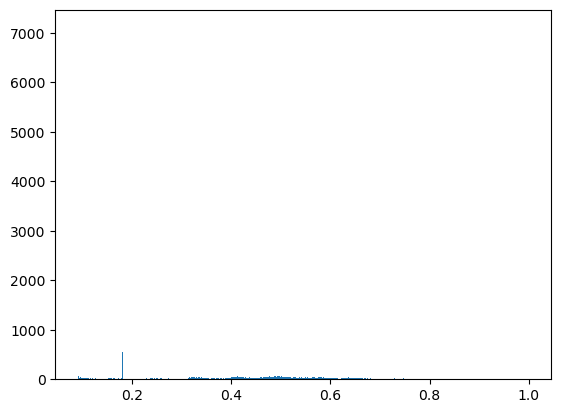

setting the output map dtype to [dtype('>f8')]
 57%|█████▋    | 29/51 [00:45<00:35,  1.62s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_r_dcr_ddec_wmean.fits
Reading  s16a_wide_v3_r_dcr_ddec_wmean.fits
Masking table...


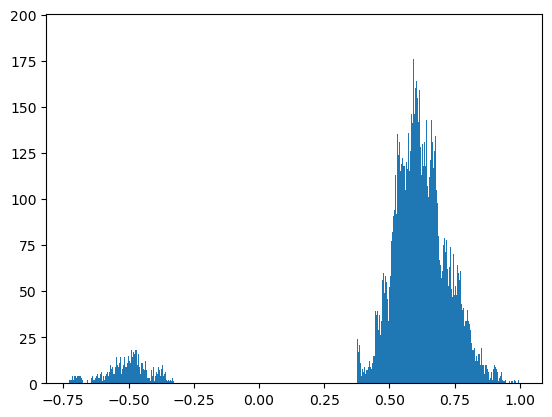

setting the output map dtype to [dtype('>f8')]
 59%|█████▉    | 30/51 [00:47<00:33,  1.62s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_i_maglim_wmean.fits
Reading  s16a_wide_v3_i_maglim_wmean.fits
Masking table...


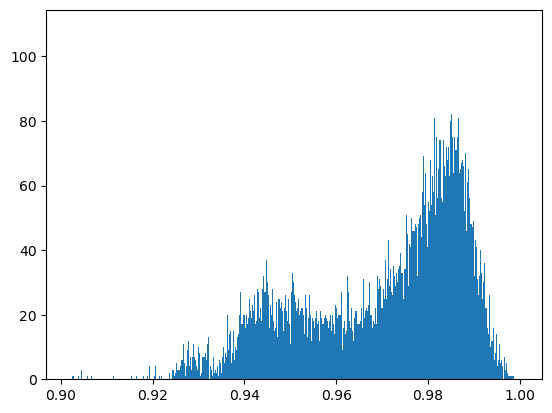

setting the output map dtype to [dtype('>f8')]
 61%|██████    | 31/51 [00:48<00:32,  1.64s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_i_skylevel_wmean.fits
Reading  s16a_wide_v3_i_skylevel_wmean.fits
Masking table...


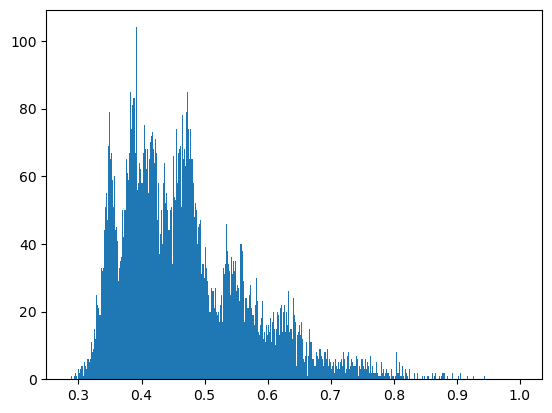

setting the output map dtype to [dtype('>f8')]
 63%|██████▎   | 32/51 [00:50<00:30,  1.63s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_r_sigma_sky_wmean.fits
Reading  s16a_wide_v3_r_sigma_sky_wmean.fits
Masking table...


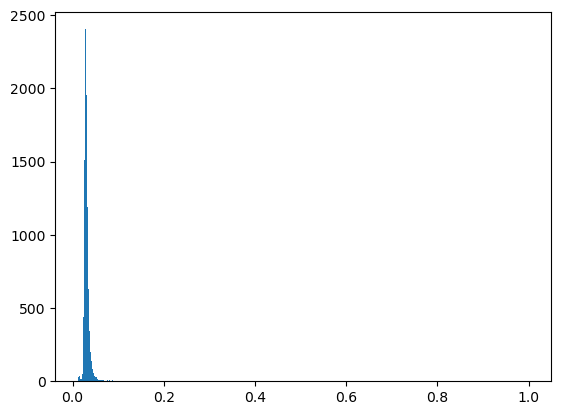

setting the output map dtype to [dtype('>f8')]
 65%|██████▍   | 33/51 [00:51<00:29,  1.61s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_g_airmass_wmean.fits
Reading  s16a_wide_v3_g_airmass_wmean.fits
Masking table...


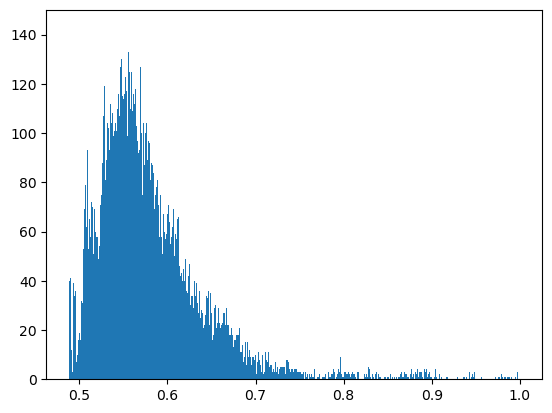

setting the output map dtype to [dtype('>f8')]
 67%|██████▋   | 34/51 [00:53<00:27,  1.61s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_z_exptime_sum.fits
Reading  s16a_wide_v3_z_exptime_sum.fits
Masking table...


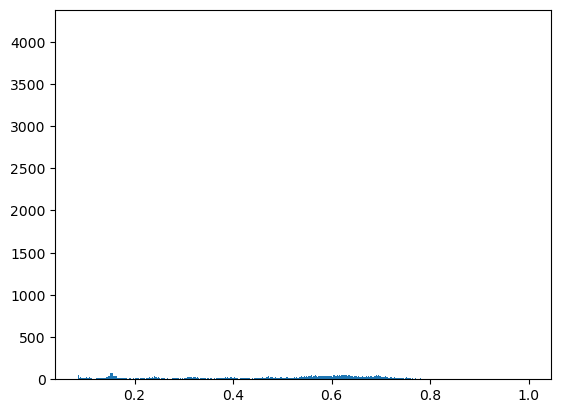

setting the output map dtype to [dtype('>f8')]
 69%|██████▊   | 35/51 [00:55<00:25,  1.60s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_g_nexp_sum.fits
Reading  s16a_wide_v3_g_nexp_sum.fits
Masking table...


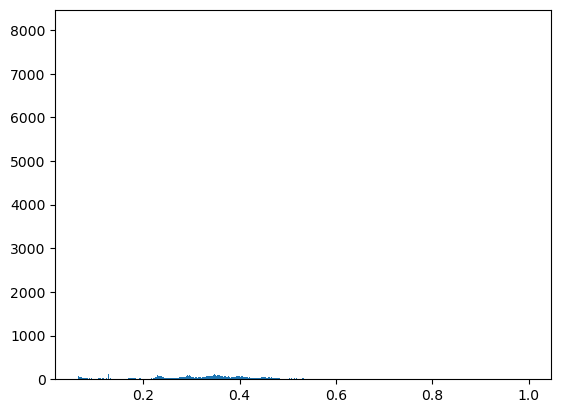

setting the output map dtype to [dtype('>f8')]
 71%|███████   | 36/51 [00:56<00:24,  1.62s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_y_nexp_sum.fits
Reading  s16a_wide_v3_y_nexp_sum.fits
Masking table...


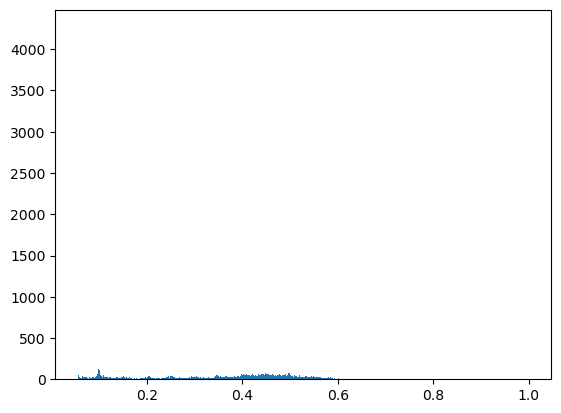

setting the output map dtype to [dtype('>f8')]
 73%|███████▎  | 37/51 [00:58<00:22,  1.62s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_y_dcr_dra_wmean.fits
Reading  s16a_wide_v3_y_dcr_dra_wmean.fits
Masking table...


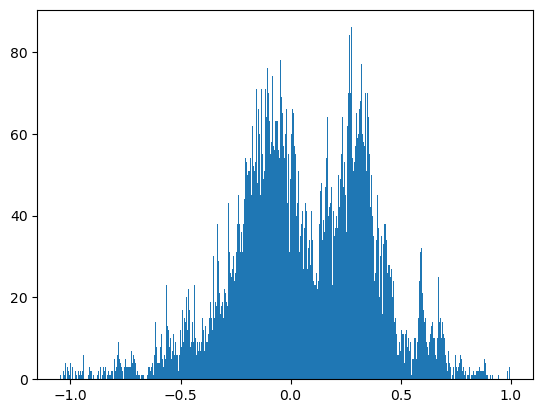

setting the output map dtype to [dtype('>f8')]
 75%|███████▍  | 38/51 [00:59<00:20,  1.60s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_z_skylevel_wmean.fits
Reading  s16a_wide_v3_z_skylevel_wmean.fits
Masking table...


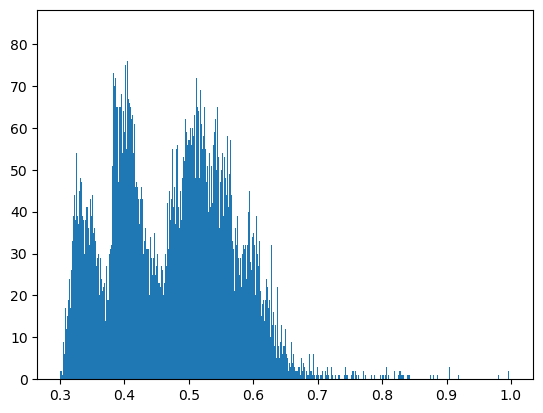

setting the output map dtype to [dtype('>f8')]
 76%|███████▋  | 39/51 [01:01<00:19,  1.60s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_r_airmass_wmean.fits
Reading  s16a_wide_v3_r_airmass_wmean.fits
Masking table...


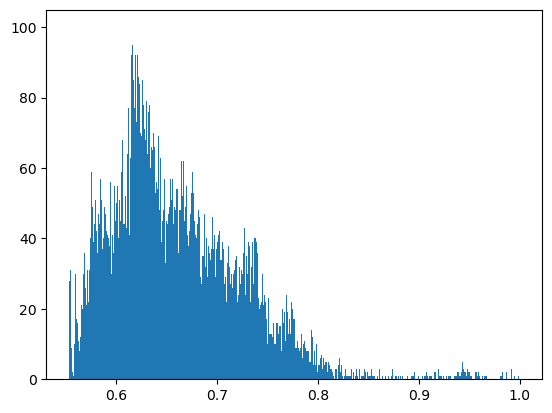

setting the output map dtype to [dtype('>f8')]
 78%|███████▊  | 40/51 [01:03<00:18,  1.64s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_r_exptime_sum.fits
Reading  s16a_wide_v3_r_exptime_sum.fits
Masking table...


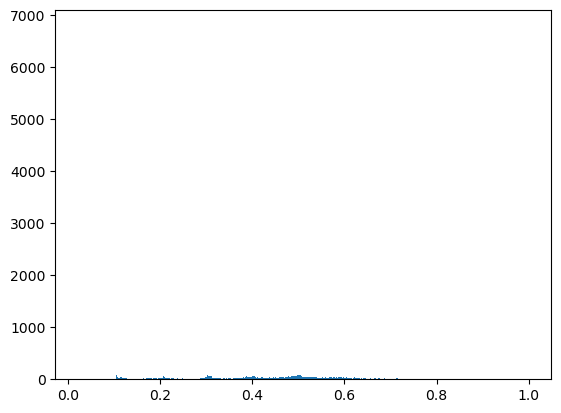

setting the output map dtype to [dtype('>f8')]
 80%|████████  | 41/51 [01:04<00:16,  1.63s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_g_weight_sum.fits
Reading  s16a_wide_v3_g_weight_sum.fits
Masking table...


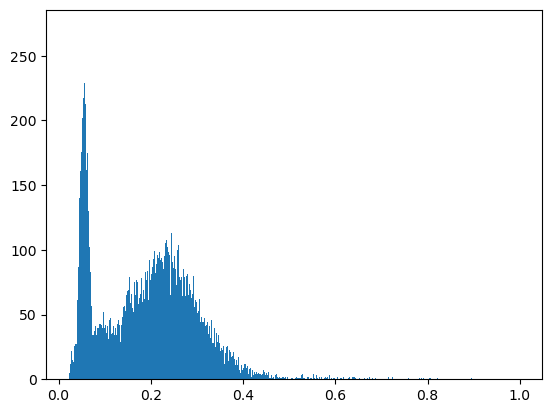

setting the output map dtype to [dtype('>f8')]
 82%|████████▏ | 42/51 [01:06<00:14,  1.62s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_y_exptime_sum.fits
Reading  s16a_wide_v3_y_exptime_sum.fits
Masking table...


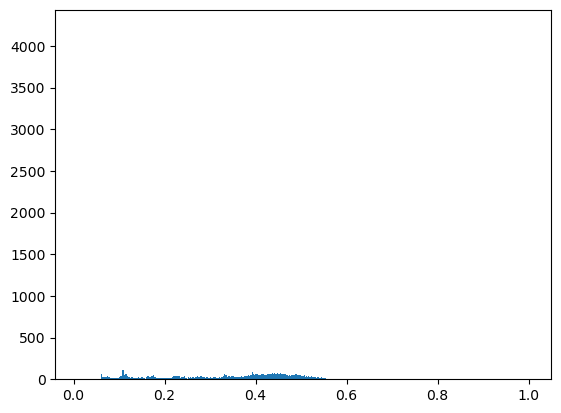

setting the output map dtype to [dtype('>f8')]
 84%|████████▍ | 43/51 [01:08<00:12,  1.61s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_z_sigma_sky_wmean.fits
Reading  s16a_wide_v3_z_sigma_sky_wmean.fits
Masking table...


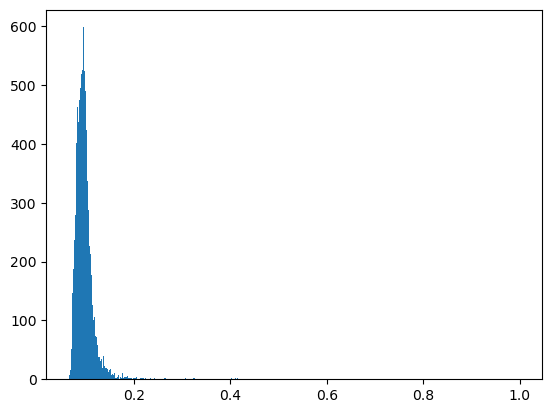

setting the output map dtype to [dtype('>f8')]
 86%|████████▋ | 44/51 [01:09<00:11,  1.60s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_g_skylevel_wmean.fits
Reading  s16a_wide_v3_g_skylevel_wmean.fits
Masking table...


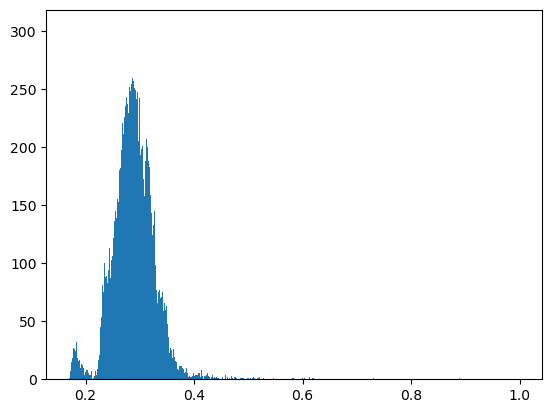

setting the output map dtype to [dtype('>f8')]
 88%|████████▊ | 45/51 [01:11<00:09,  1.63s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_i_dcr_ddec_wmean.fits
Reading  s16a_wide_v3_i_dcr_ddec_wmean.fits
Masking table...


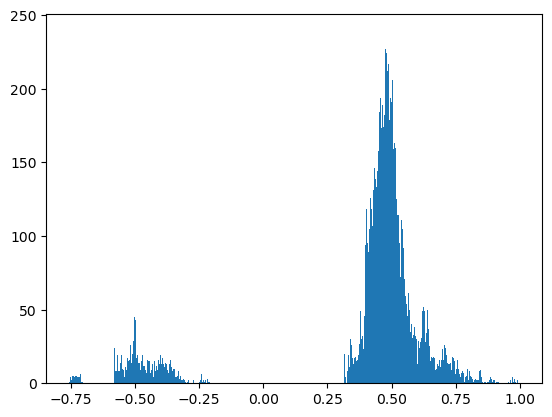

setting the output map dtype to [dtype('>f8')]
 90%|█████████ | 46/51 [01:12<00:08,  1.62s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_i_dcr_dra_wmean.fits
Reading  s16a_wide_v3_i_dcr_dra_wmean.fits
Masking table...


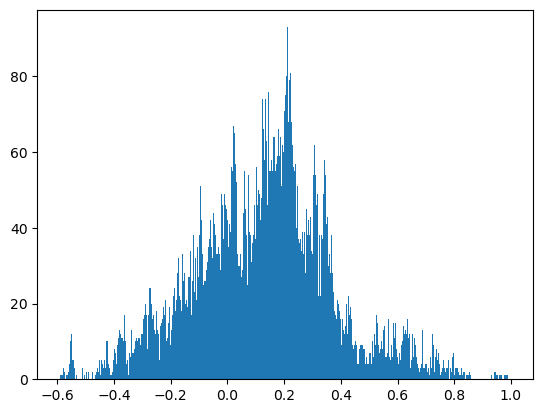

setting the output map dtype to [dtype('>f8')]
 92%|█████████▏| 47/51 [01:14<00:06,  1.61s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_g_dcr_ddec_wmean.fits
Reading  s16a_wide_v3_g_dcr_ddec_wmean.fits
Masking table...


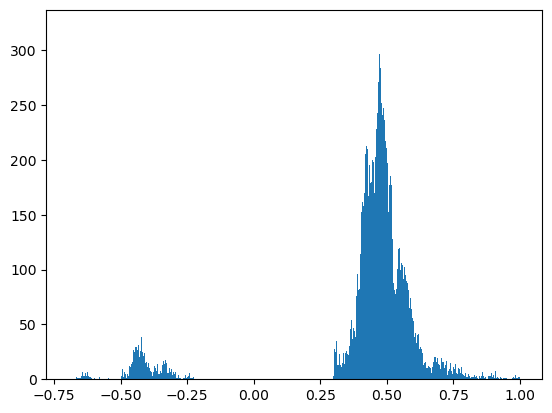

setting the output map dtype to [dtype('>f8')]
 94%|█████████▍| 48/51 [01:16<00:04,  1.59s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_i_nexp_sum.fits
Reading  s16a_wide_v3_i_nexp_sum.fits
Masking table...


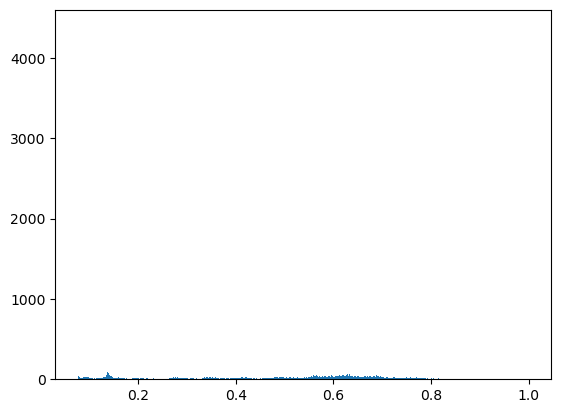

setting the output map dtype to [dtype('>f8')]
 96%|█████████▌| 49/51 [01:17<00:03,  1.61s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_r_dcr_dra_wmean.fits
Reading  s16a_wide_v3_r_dcr_dra_wmean.fits
Masking table...


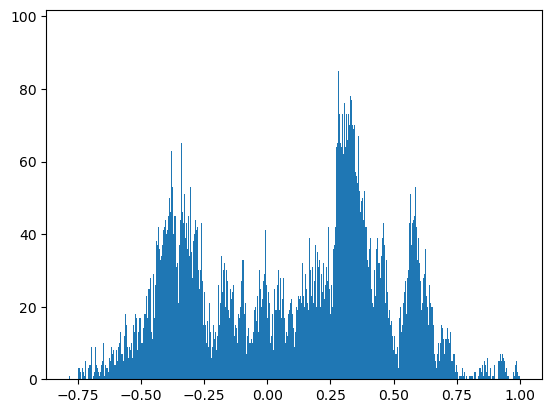

setting the output map dtype to [dtype('>f8')]
 98%|█████████▊| 50/51 [01:19<00:01,  1.60s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/scalars/s16a_wide_v3_z_seeing_wmean.fits
Reading  s16a_wide_v3_z_seeing_wmean.fits
Masking table...


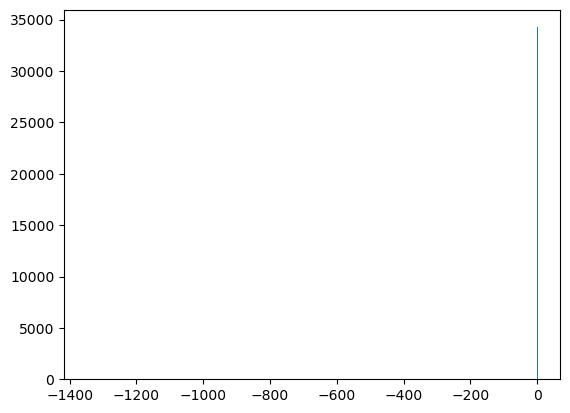

setting the output map dtype to [dtype('>f8')]
100%|██████████| 51/51 [01:20<00:00,  1.59s/it]


Normalizing SP maps at nside = 2048
Path '/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/normalized' created successfully.
/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars


  0%|          | 0/51 [00:00<?, ?it/s]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_r_weight_sum.fits
Reading  s16a_wide_v3_r_weight_sum.fits
Masking table...


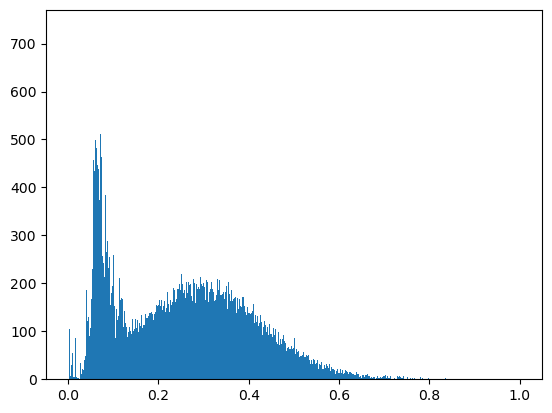

setting the output map dtype to [dtype('>f8')]
  2%|▏         | 1/51 [00:06<05:40,  6.80s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_g_maglim_wmean.fits
Reading  s16a_wide_v3_g_maglim_wmean.fits
Masking table...


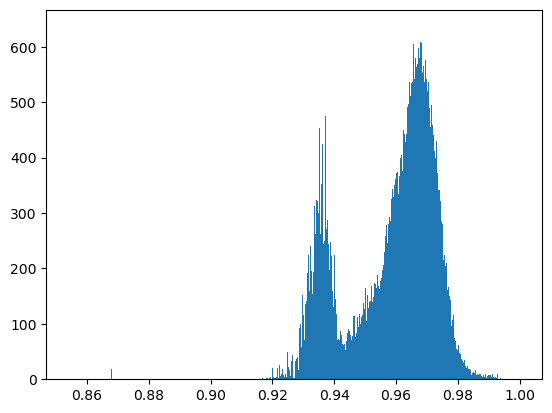

setting the output map dtype to [dtype('>f8')]
  4%|▍         | 2/51 [00:13<05:34,  6.83s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_g_sigma_sky_wmean.fits
Reading  s16a_wide_v3_g_sigma_sky_wmean.fits
Masking table...


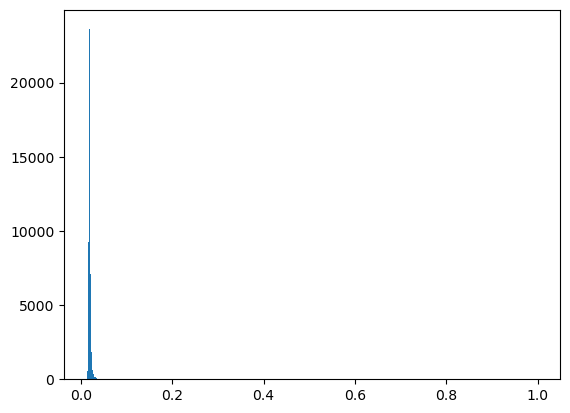

setting the output map dtype to [dtype('>f8')]
  6%|▌         | 3/51 [00:20<05:31,  6.91s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_z_dcr_dra_wmean.fits
Reading  s16a_wide_v3_z_dcr_dra_wmean.fits
Masking table...


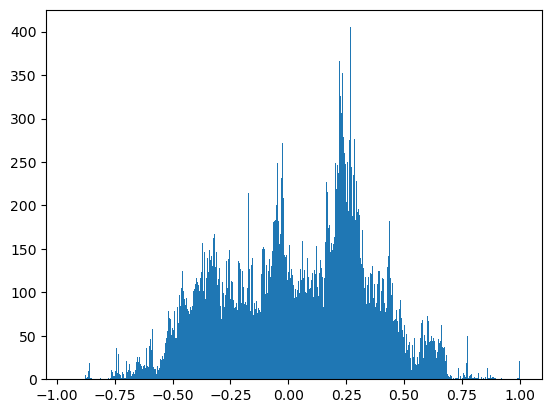

setting the output map dtype to [dtype('>f8')]
  8%|▊         | 4/51 [00:27<05:21,  6.84s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_g_exptime_sum.fits
Reading  s16a_wide_v3_g_exptime_sum.fits
Masking table...


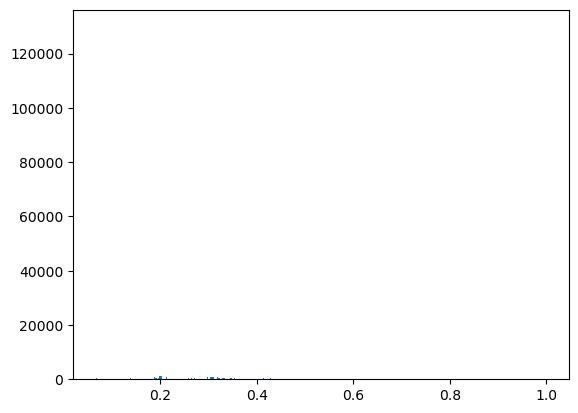

setting the output map dtype to [dtype('>f8')]
 10%|▉         | 5/51 [00:34<05:14,  6.83s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_y_sigma_sky_wmean.fits
Reading  s16a_wide_v3_y_sigma_sky_wmean.fits
Masking table...


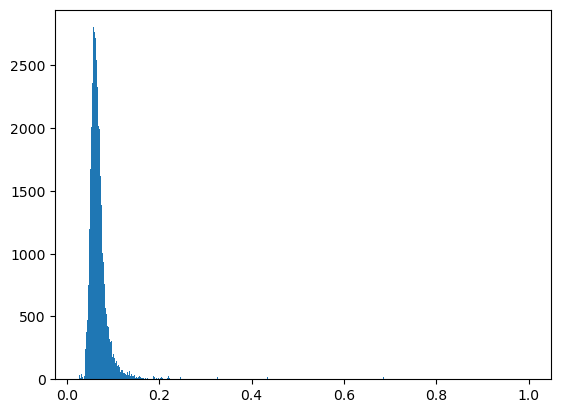

setting the output map dtype to [dtype('>f8')]
 12%|█▏        | 6/51 [00:41<05:08,  6.85s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_y_skylevel_wmean.fits
Reading  s16a_wide_v3_y_skylevel_wmean.fits
Masking table...


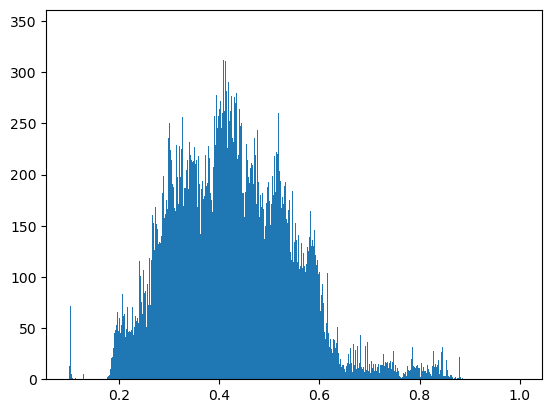

setting the output map dtype to [dtype('>f8')]
 14%|█▎        | 7/51 [00:47<05:00,  6.82s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_y_seeing_wmean.fits
Reading  s16a_wide_v3_y_seeing_wmean.fits
Masking table...


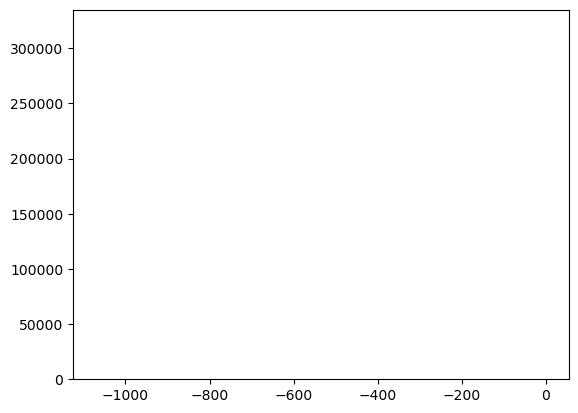

setting the output map dtype to [dtype('>f8')]
 16%|█▌        | 8/51 [00:54<04:53,  6.82s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_r_seeing_wmean.fits
Reading  s16a_wide_v3_r_seeing_wmean.fits
Masking table...


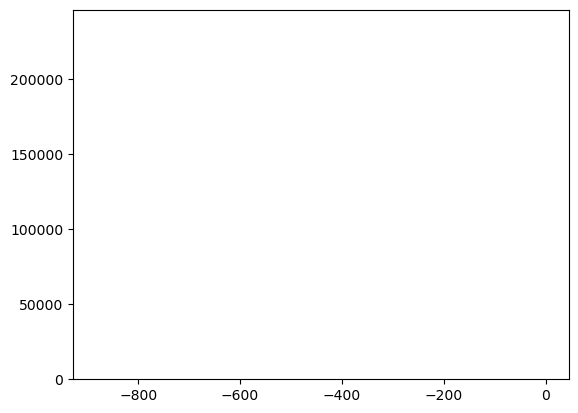

setting the output map dtype to [dtype('>f8')]
 18%|█▊        | 9/51 [01:01<04:44,  6.77s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_z_dcr_ddec_wmean.fits
Reading  s16a_wide_v3_z_dcr_ddec_wmean.fits
Masking table...


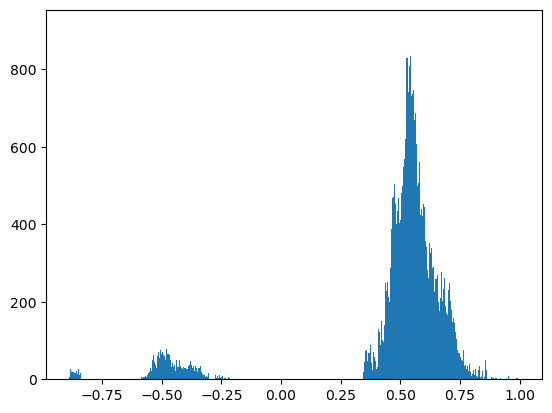

setting the output map dtype to [dtype('>f8')]
 20%|█▉        | 10/51 [01:07<04:36,  6.73s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_r_maglim_wmean.fits
Reading  s16a_wide_v3_r_maglim_wmean.fits
Masking table...


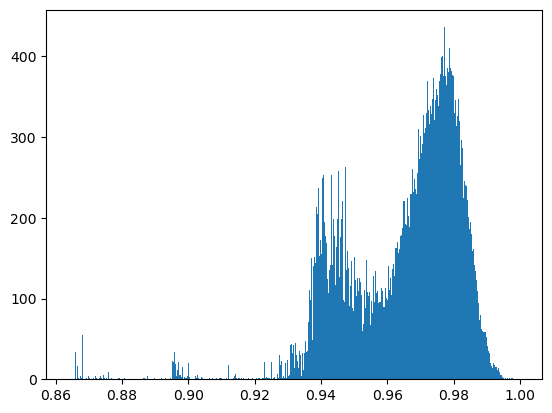

setting the output map dtype to [dtype('>f8')]
 22%|██▏       | 11/51 [01:14<04:30,  6.75s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_i_airmass_wmean.fits
Reading  s16a_wide_v3_i_airmass_wmean.fits
Masking table...


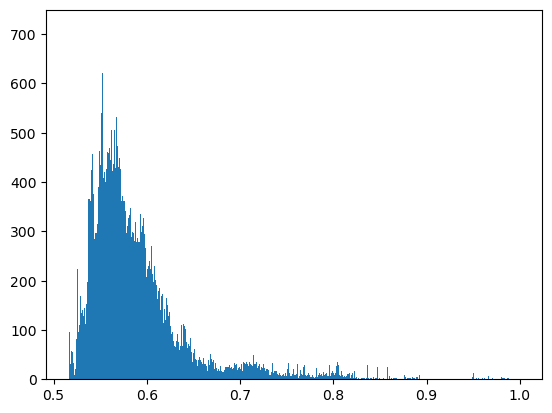

setting the output map dtype to [dtype('>f8')]
 25%|██▌       | 13/51 [01:21<03:17,  5.21s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_z_airmass_wmean.fits
Reading  s16a_wide_v3_z_airmass_wmean.fits
Masking table...


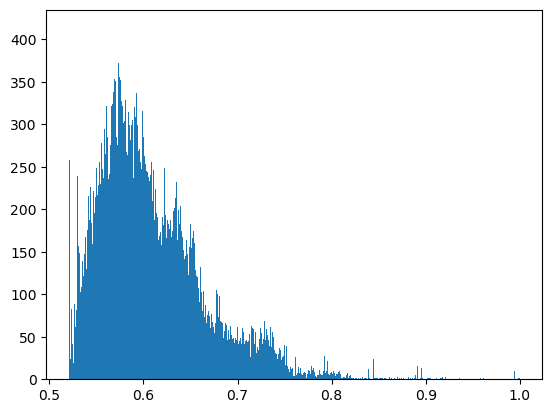

setting the output map dtype to [dtype('>f8')]
 27%|██▋       | 14/51 [01:28<03:27,  5.61s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_z_nexp_sum.fits
Reading  s16a_wide_v3_z_nexp_sum.fits
Masking table...


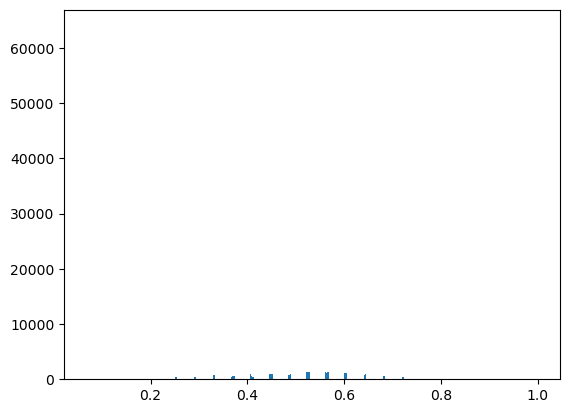

setting the output map dtype to [dtype('>f8')]
 29%|██▉       | 15/51 [01:35<03:32,  5.90s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_i_weight_sum.fits
Reading  s16a_wide_v3_i_weight_sum.fits
Masking table...


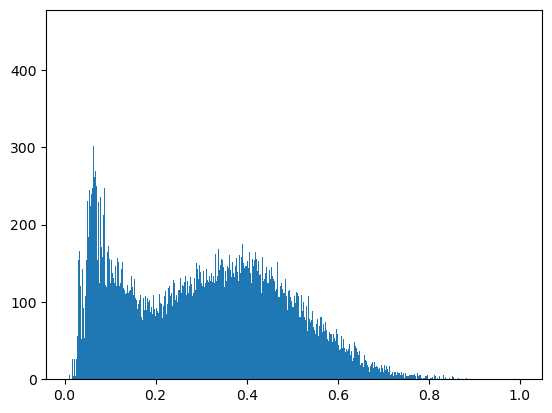

setting the output map dtype to [dtype('>f8')]
 31%|███▏      | 16/51 [01:41<03:34,  6.13s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_i_sigma_sky_wmean.fits
Reading  s16a_wide_v3_i_sigma_sky_wmean.fits
Masking table...


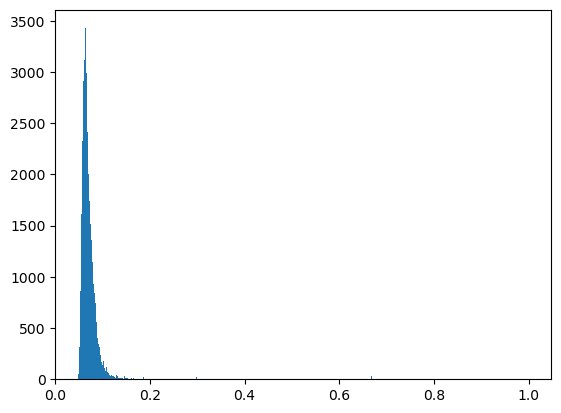

setting the output map dtype to [dtype('>f8')]
 33%|███▎      | 17/51 [01:48<03:35,  6.33s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_r_skylevel_wmean.fits
Reading  s16a_wide_v3_r_skylevel_wmean.fits
Masking table...


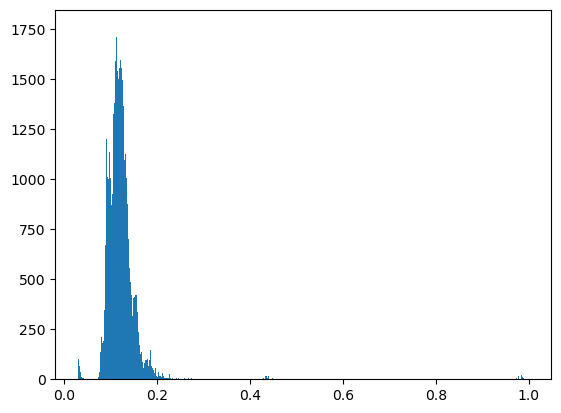

setting the output map dtype to [dtype('>f8')]
 35%|███▌      | 18/51 [01:55<03:32,  6.44s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_g_dcr_dra_wmean.fits
Reading  s16a_wide_v3_g_dcr_dra_wmean.fits
Masking table...


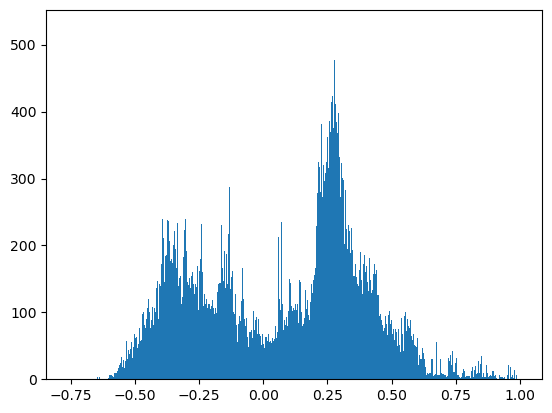

setting the output map dtype to [dtype('>f8')]
 37%|███▋      | 19/51 [02:02<03:32,  6.65s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_y_dcr_ddec_wmean.fits
Reading  s16a_wide_v3_y_dcr_ddec_wmean.fits
Masking table...


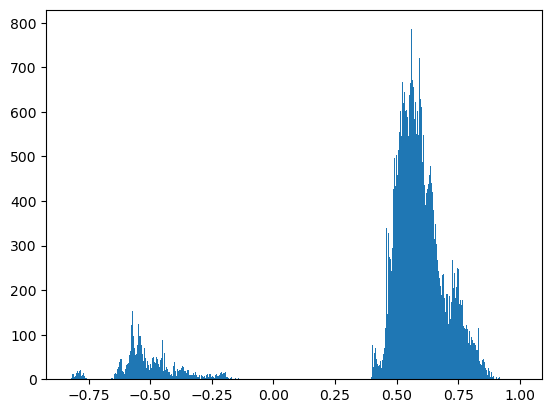

setting the output map dtype to [dtype('>f8')]
 39%|███▉      | 20/51 [02:09<03:29,  6.77s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_y_weight_sum.fits
Reading  s16a_wide_v3_y_weight_sum.fits
Masking table...


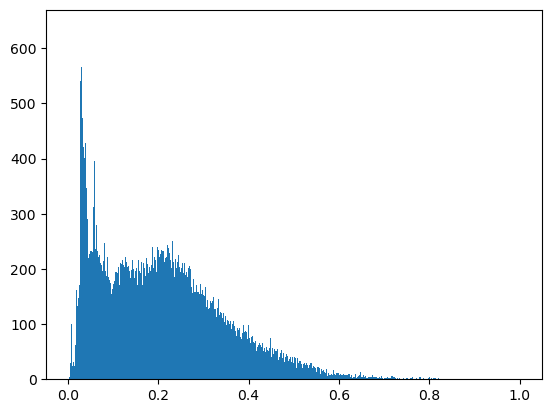

setting the output map dtype to [dtype('>f8')]
 41%|████      | 21/51 [02:17<03:27,  6.93s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_i_exptime_sum.fits
Reading  s16a_wide_v3_i_exptime_sum.fits
Masking table...


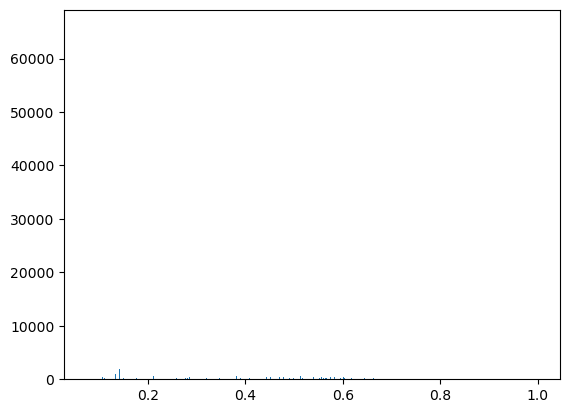

setting the output map dtype to [dtype('>f8')]
 43%|████▎     | 22/51 [02:23<03:18,  6.84s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_z_maglim_wmean.fits
Reading  s16a_wide_v3_z_maglim_wmean.fits
Masking table...


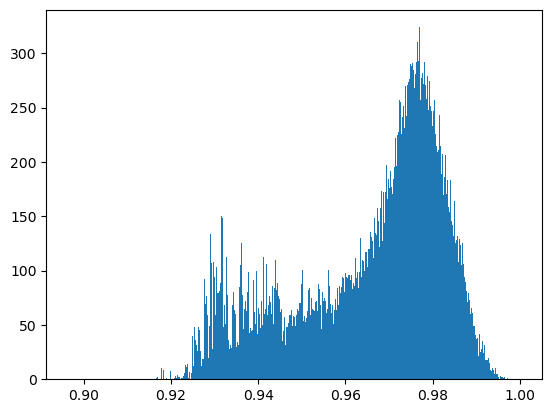

setting the output map dtype to [dtype('>f8')]
 45%|████▌     | 23/51 [02:30<03:10,  6.80s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_z_weight_sum.fits
Reading  s16a_wide_v3_z_weight_sum.fits
Masking table...


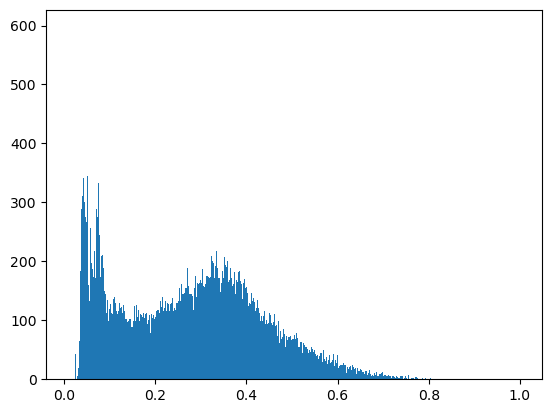

setting the output map dtype to [dtype('>f8')]
 47%|████▋     | 24/51 [02:37<03:03,  6.78s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_y_maglim_wmean.fits
Reading  s16a_wide_v3_y_maglim_wmean.fits
Masking table...


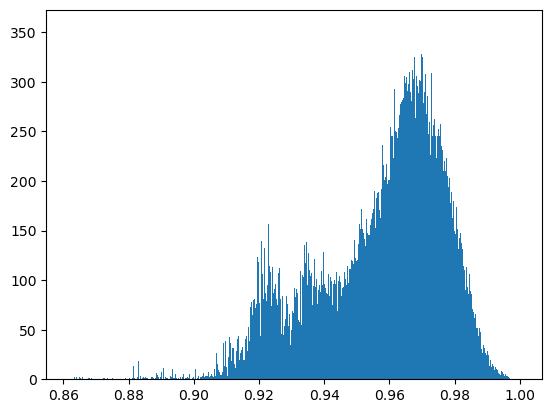

setting the output map dtype to [dtype('>f8')]
 49%|████▉     | 25/51 [02:43<02:56,  6.78s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_y_airmass_wmean.fits
Reading  s16a_wide_v3_y_airmass_wmean.fits
Masking table...


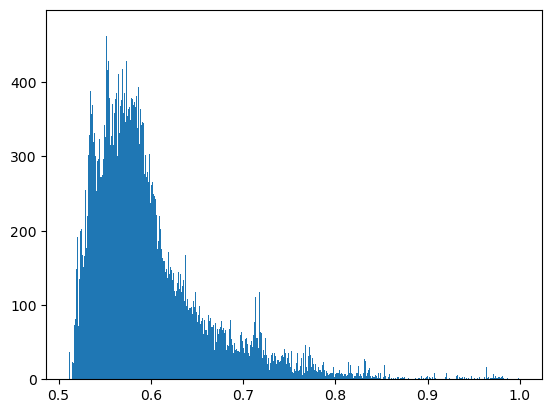

setting the output map dtype to [dtype('>f8')]
 51%|█████     | 26/51 [02:50<02:49,  6.79s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_i_seeing_wmean.fits
Reading  s16a_wide_v3_i_seeing_wmean.fits
Masking table...


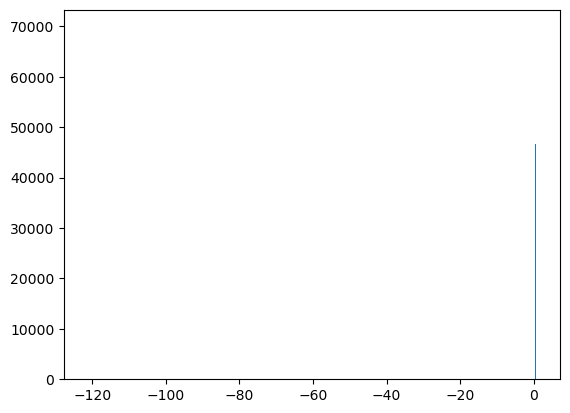

setting the output map dtype to [dtype('>f8')]
 53%|█████▎    | 27/51 [02:57<02:43,  6.82s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_g_seeing_wmean.fits
Reading  s16a_wide_v3_g_seeing_wmean.fits
Masking table...


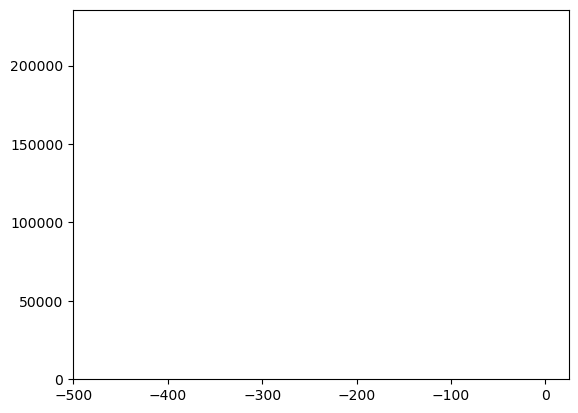

setting the output map dtype to [dtype('>f8')]
 55%|█████▍    | 28/51 [03:04<02:36,  6.80s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_r_nexp_sum.fits
Reading  s16a_wide_v3_r_nexp_sum.fits
Masking table...


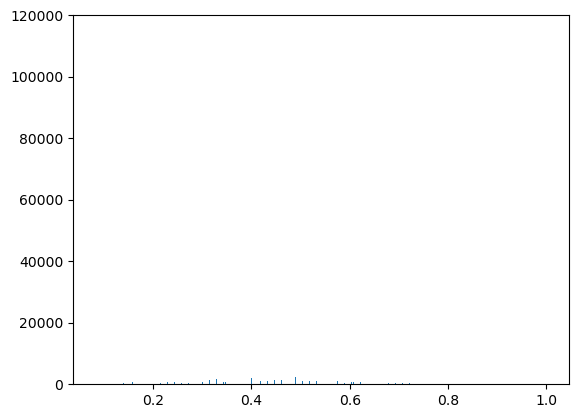

setting the output map dtype to [dtype('>f8')]
 57%|█████▋    | 29/51 [03:11<02:29,  6.81s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_r_dcr_ddec_wmean.fits
Reading  s16a_wide_v3_r_dcr_ddec_wmean.fits
Masking table...


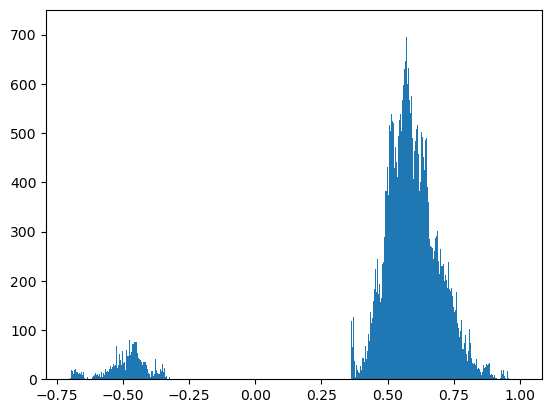

setting the output map dtype to [dtype('>f8')]
 59%|█████▉    | 30/51 [03:18<02:23,  6.83s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_i_maglim_wmean.fits
Reading  s16a_wide_v3_i_maglim_wmean.fits
Masking table...


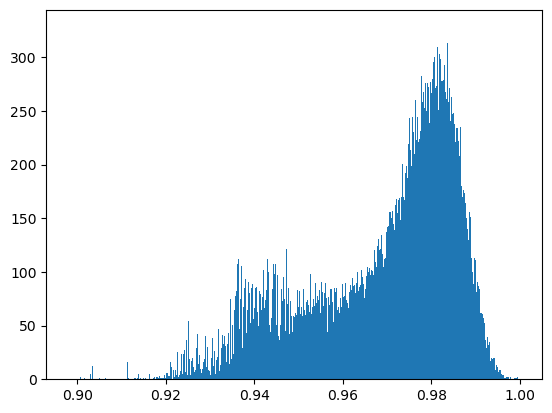

setting the output map dtype to [dtype('>f8')]
 61%|██████    | 31/51 [03:24<02:16,  6.82s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_i_skylevel_wmean.fits
Reading  s16a_wide_v3_i_skylevel_wmean.fits
Masking table...


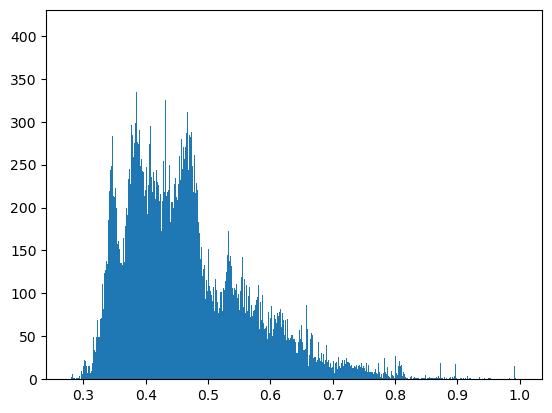

setting the output map dtype to [dtype('>f8')]
 63%|██████▎   | 32/51 [03:31<02:09,  6.83s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_r_sigma_sky_wmean.fits
Reading  s16a_wide_v3_r_sigma_sky_wmean.fits
Masking table...


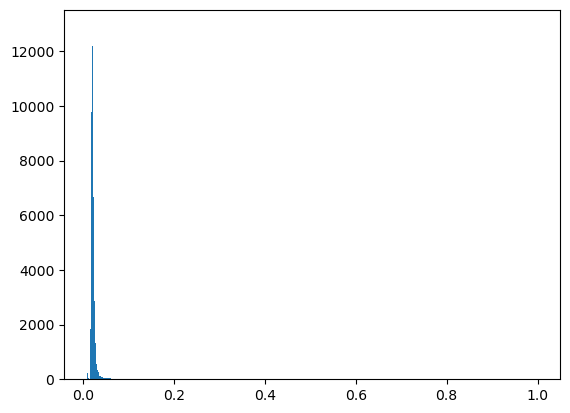

setting the output map dtype to [dtype('>f8')]
 65%|██████▍   | 33/51 [03:38<02:03,  6.84s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_g_airmass_wmean.fits
Reading  s16a_wide_v3_g_airmass_wmean.fits
Masking table...


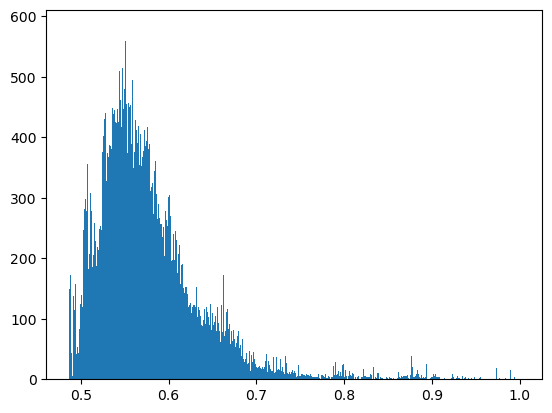

setting the output map dtype to [dtype('>f8')]
 67%|██████▋   | 34/51 [03:45<01:57,  6.90s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_z_exptime_sum.fits
Reading  s16a_wide_v3_z_exptime_sum.fits
Masking table...


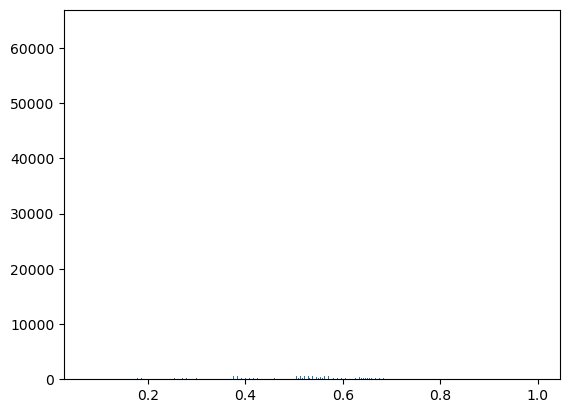

setting the output map dtype to [dtype('>f8')]
 69%|██████▊   | 35/51 [03:52<01:50,  6.93s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_g_nexp_sum.fits
Reading  s16a_wide_v3_g_nexp_sum.fits
Masking table...


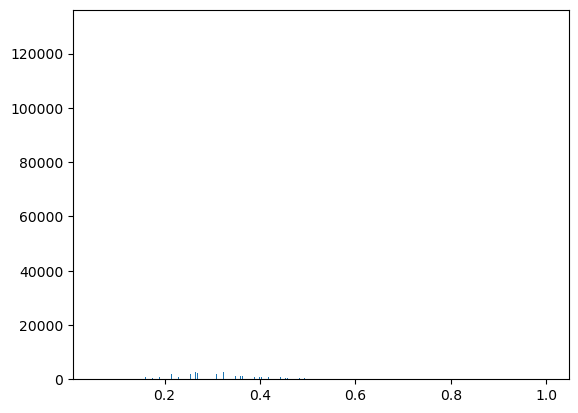

setting the output map dtype to [dtype('>f8')]
 71%|███████   | 36/51 [03:59<01:42,  6.83s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_y_nexp_sum.fits
Reading  s16a_wide_v3_y_nexp_sum.fits
Masking table...


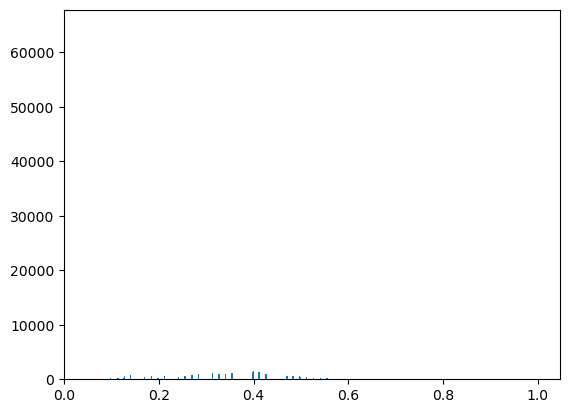

setting the output map dtype to [dtype('>f8')]
 73%|███████▎  | 37/51 [04:06<01:36,  6.87s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_y_dcr_dra_wmean.fits
Reading  s16a_wide_v3_y_dcr_dra_wmean.fits
Masking table...


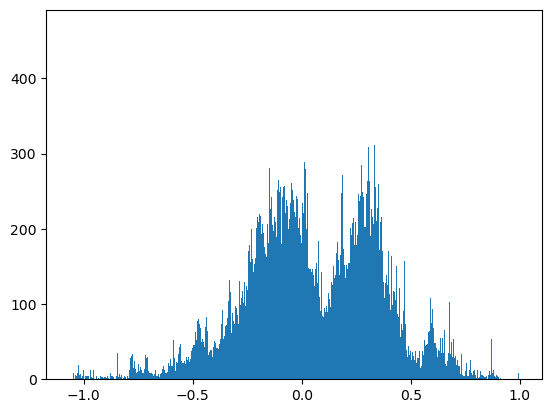

setting the output map dtype to [dtype('>f8')]
 75%|███████▍  | 38/51 [04:13<01:30,  6.93s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_z_skylevel_wmean.fits
Reading  s16a_wide_v3_z_skylevel_wmean.fits
Masking table...


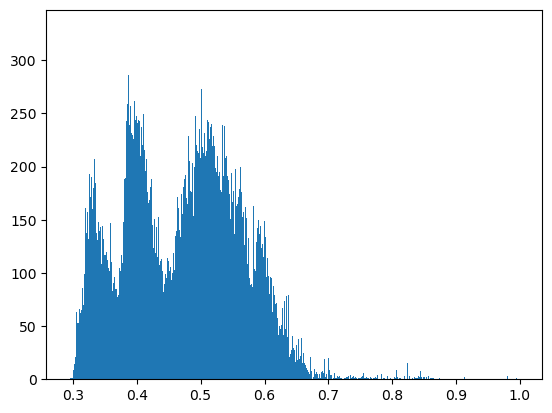

setting the output map dtype to [dtype('>f8')]
 76%|███████▋  | 39/51 [04:20<01:23,  6.96s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_r_airmass_wmean.fits
Reading  s16a_wide_v3_r_airmass_wmean.fits
Masking table...


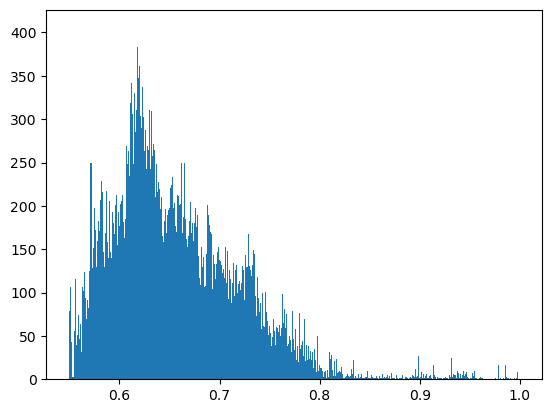

setting the output map dtype to [dtype('>f8')]
 78%|███████▊  | 40/51 [04:27<01:15,  6.91s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_r_exptime_sum.fits
Reading  s16a_wide_v3_r_exptime_sum.fits
Masking table...


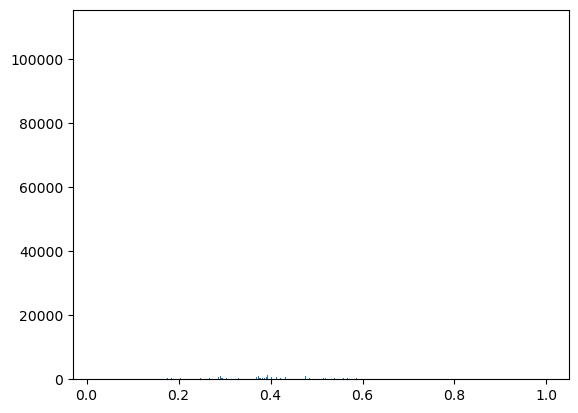

setting the output map dtype to [dtype('>f8')]
 80%|████████  | 41/51 [04:34<01:09,  6.94s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_g_weight_sum.fits
Reading  s16a_wide_v3_g_weight_sum.fits
Masking table...


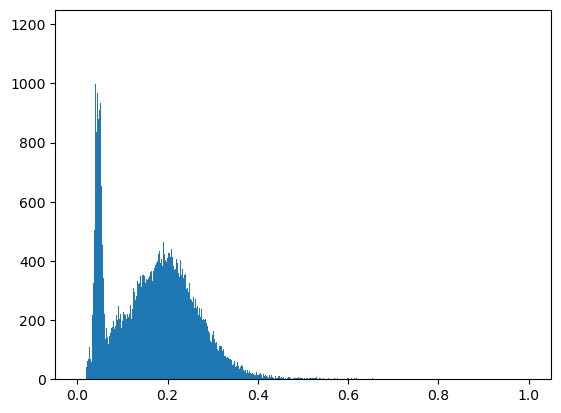

setting the output map dtype to [dtype('>f8')]
 82%|████████▏ | 42/51 [04:41<01:02,  6.98s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_y_exptime_sum.fits
Reading  s16a_wide_v3_y_exptime_sum.fits
Masking table...


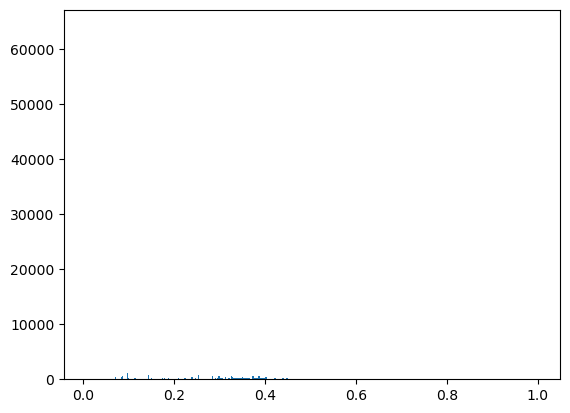

setting the output map dtype to [dtype('>f8')]
 84%|████████▍ | 43/51 [04:48<00:55,  7.00s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_z_sigma_sky_wmean.fits
Reading  s16a_wide_v3_z_sigma_sky_wmean.fits
Masking table...


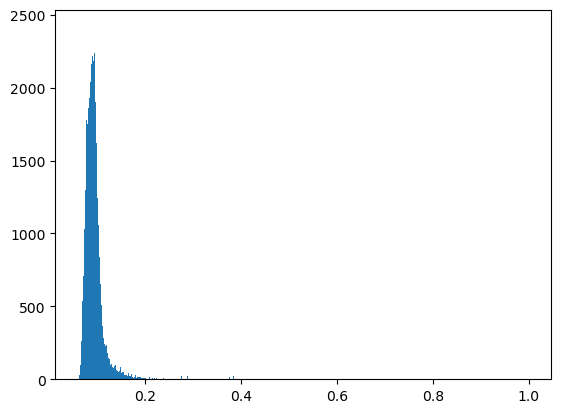

setting the output map dtype to [dtype('>f8')]
 86%|████████▋ | 44/51 [04:55<00:49,  7.00s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_g_skylevel_wmean.fits
Reading  s16a_wide_v3_g_skylevel_wmean.fits
Masking table...


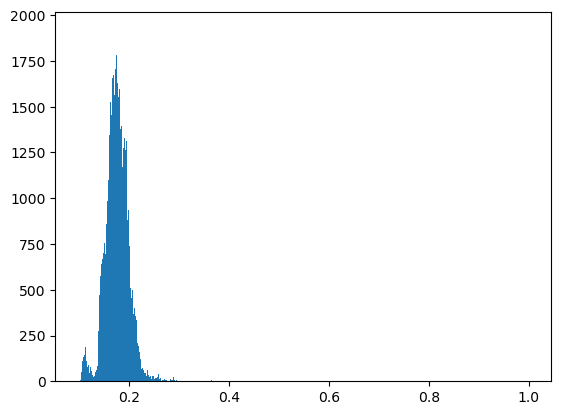

setting the output map dtype to [dtype('>f8')]
 88%|████████▊ | 45/51 [05:02<00:42,  7.01s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_i_dcr_ddec_wmean.fits
Reading  s16a_wide_v3_i_dcr_ddec_wmean.fits
Masking table...


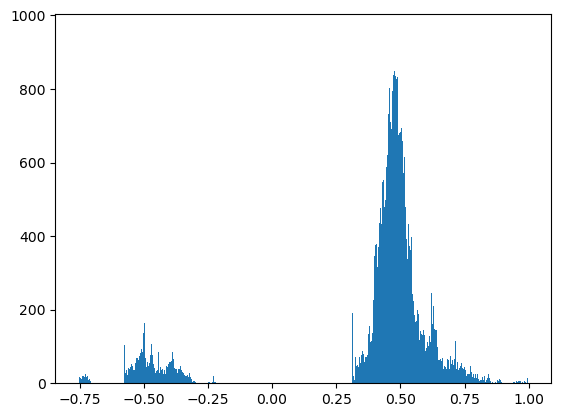

setting the output map dtype to [dtype('>f8')]
 90%|█████████ | 46/51 [05:09<00:35,  7.18s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_i_dcr_dra_wmean.fits
Reading  s16a_wide_v3_i_dcr_dra_wmean.fits
Masking table...


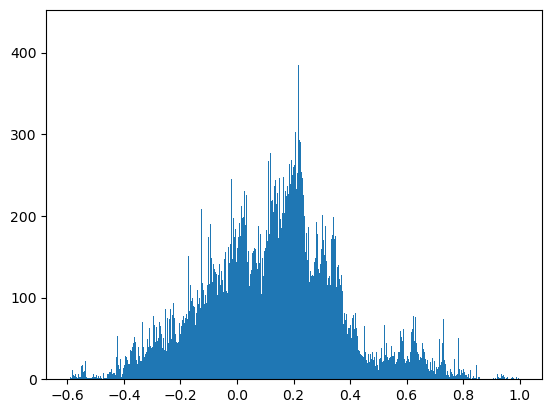

setting the output map dtype to [dtype('>f8')]
 92%|█████████▏| 47/51 [05:16<00:28,  7.18s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_g_dcr_ddec_wmean.fits
Reading  s16a_wide_v3_g_dcr_ddec_wmean.fits
Masking table...


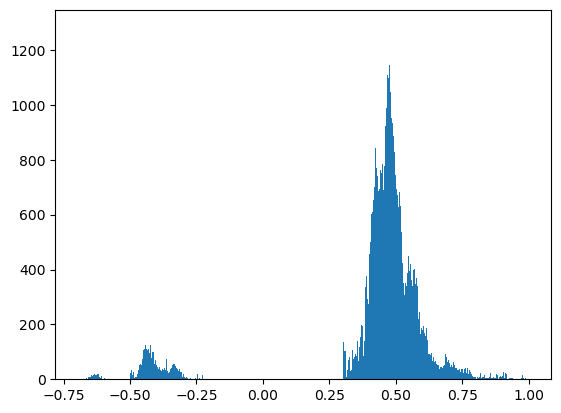

setting the output map dtype to [dtype('>f8')]
 94%|█████████▍| 48/51 [05:24<00:21,  7.20s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_i_nexp_sum.fits
Reading  s16a_wide_v3_i_nexp_sum.fits
Masking table...


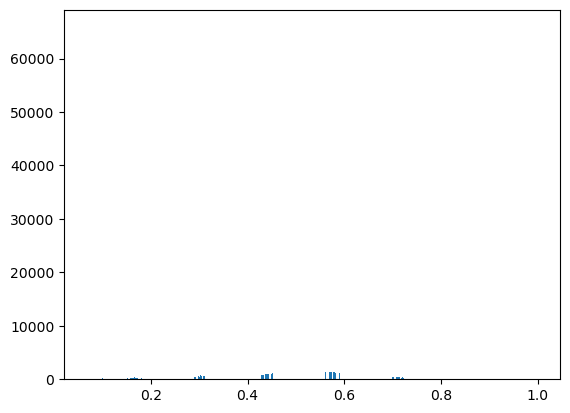

setting the output map dtype to [dtype('>f8')]
 96%|█████████▌| 49/51 [05:31<00:14,  7.15s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_r_dcr_dra_wmean.fits
Reading  s16a_wide_v3_r_dcr_dra_wmean.fits
Masking table...


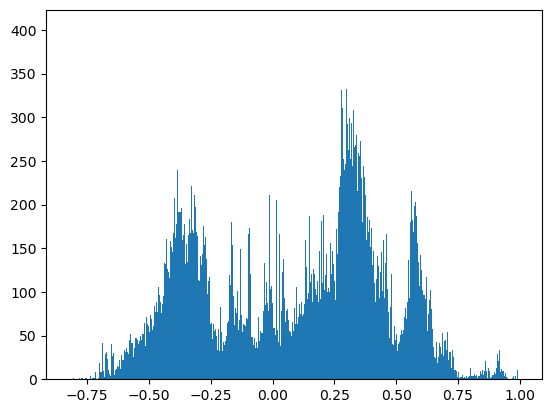

setting the output map dtype to [dtype('>f8')]
 98%|█████████▊| 50/51 [05:38<00:07,  7.06s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/scalars/s16a_wide_v3_z_seeing_wmean.fits
Reading  s16a_wide_v3_z_seeing_wmean.fits
Masking table...


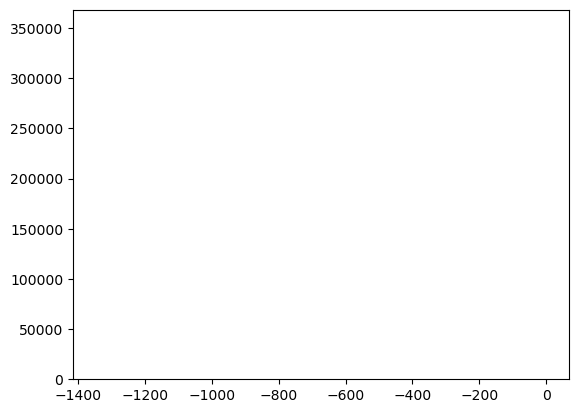

setting the output map dtype to [dtype('>f8')]
100%|██████████| 51/51 [05:44<00:00,  6.76s/it]


In [5]:
### Tensor maps
path_proj = "/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/"

for nside in np.array([512,2048]):
    print(f'Normalizing SP maps at nside = {nside}')
    # Just applying PCA to scalar maps
    if nside == 512:
        path_sys_maps = os.path.join(path_proj, "systematics_maps/maps_512/scalars")
    elif nside == 2048:
        path_sys_maps = os.path.join(path_proj, "systematics_maps/maps_2048/scalars")
    path_to_save = os.path.join(path_sys_maps, "normalized")
    if not os.path.exists(path_to_save):
        os.makedirs(path_to_save)
        print(f"Path '{path_to_save}' created successfully.")
    else:
        print(f"Path '{path_to_save}' already exists.")
    print(path_sys_maps)
    for map_name in tqdm(os.listdir(path_sys_maps)):
        if "s16a" in map_name:
            fname_sys = os.path.join(path_sys_maps, map_name)
            print(fname_sys)
            print('Reading ', map_name)
            with fits.open(fname_sys) as data:
                print('Masking table...')
                map_ = data[0].data

            # plt.hist(map_[map_ != hp.UNSEEN],bins=int(np.sqrt(len(map_))))
            # plt.show()

            # Normalization
            map_[map_ != hp.UNSEEN] /= max(map_[map_ != hp.UNSEEN])

            plt.hist(map_[map_ != hp.UNSEEN],bins=int(np.sqrt(len(map_))))
            plt.show()

            # Saving normalized maps
            hp.write_map(os.path.join(path_to_save, 'norm_'+map_name), map_, nest=False, overwrite=True)

## Principal Component Analysis (PCA) over observing conditions maps

Monday November 8th

VARIANT: In this script we consider the previous PCA script and consider the selection of the amount of PCA maps following this tutorial https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/ , this is, what is the necessary amount of maps to account the 98% of the variance?


Example taken from this tutorial (https://towardsdatascience.com/dive-into-pca-principal-component-analysis-with-python-43ded13ead21)

The goal of this script is to reduce the dimensionality of the systematic maps introduced in NaMaster (via TXPipe) in order to produce a deprojected (mode deprojection technique) data vector. Our objective is to reduce the information contained in the whole set of maps into 4 or 5 maps, obtained from PCA, which describes the majority of the information (approx. 85% of the variance)

WARNING! This is an Unsupervised method so the density should not be introduced as target.

In [7]:
from tqdm import tqdm
import h5py
import os
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

**1st step** Generate a table where each column is a systematic map and the final column acting as 'target' is the density of a given redshift bin.

In [ ]:
# Paths
path_proj = "/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data"
# Just applying PCA to scalar maps
nside = 512
path_sys_maps = os.path.join(path_proj, f"systematics_maps/maps_{nside}/scalars/normalized")
path_dens_map = "/pscratch/sd/d/davidsan/txpipe-reanalysis/hsc/new_covariance_measurements/outputs_all_updated_mask"
path_to_save = os.path.join(path_proj, f"systematics_maps/maps_{nside}/scalars/PCA")
path_to_save_figs = os.path.join(path_proj, f"systematics_maps/figures_nside{nside}")

In [ ]:
# Appending observing condition maps as columns and density map as target
fname_mask = os.path.join(path_dens_map, 'mask.hdf5')
df_pix_mask = pd.DataFrame(np.array(h5py.File(fname_mask)['maps']['mask']['pixel']).byteswap().newbyteorder())

# Just consider pixels in the mask
mask_array = np.reshape(df_pix_mask.to_numpy(), np.shape(df_pix_mask.to_numpy())[0])

In [ ]:
# Read systematic map
i = 0
for map_name in tqdm(os.listdir(path_sys_maps)):
    if 's16a' in map_name:
        fname_sys = os.path.join(path_sys_maps, map_name)
        print('Reading ', map_name)
        with fits.open(fname_sys) as data:
            print('Masking table...')
            df = data[0].data[mask_array]

        # Creating dataframe
        df = pd.DataFrame(data=df, index=mask_array)

        # Naming each column
        df.columns = [map_name[13:-5]]

        if i == 0:
            df_all = df
        else:
            print('Concatenating...')
            df_all = pd.concat([df_all, df], axis=1)

        i += 1

In [ ]:
# Redshift bin index (think how to consider all z-bins)
j = 0
fname_dens = os.path.join(path_dens_map, 'density_maps.hdf5')
df_value = pd.DataFrame(np.array(h5py.File(fname_dens)['maps'][f'delta_{j}']['value']))
df_pix = pd.DataFrame(np.array(h5py.File(fname_dens)['maps'][f'delta_{j}']['pixel']))
dens_map = np.ones(12*2048**2) * hp.UNSEEN
dens_map[np.array(df_pix)] = np.array(df_value)
dens_df = pd.DataFrame(data=dens_map)
dens_df.columns = [f'dens_zbin_{j}']

In [ ]:
# Mask
print('Masking table...')
# Keep rows (rows = pixel index) on the mask to avoid hp.UNSEEN
dens_df = dens_df.iloc[mask_array]

In [ ]:
print('Appending target...')
df_all = pd.concat([df_all, dens_df], axis=1)

cond = df_all.to_numpy() == hp.UNSEEN
print('Any hp.UNSEEN in masked table?', np.any(cond))

In [ ]:
df_all = df_all.drop(columns=['dens_zbin_0'])

**2nd step** Proceed with PCA

In [ ]:
scaler=MinMaxScaler()#instantiateu

In [ ]:
scaler.fit(df_all) # compute the mean and standard which will be used in the next command

In [ ]:
df_scaled = scaler.transform(df_all)

In [ ]:
df_scaled = pd.DataFrame(scaler.fit_transform(df_all), columns = df_all.columns)

In [ ]:
df_scaled

In [ ]:
print(plt.hist(df_scaled['z_seeing_wmean']))

In [ ]:
pca=PCA(n_components=0.98) 

In [ ]:
pca.fit(df_scaled.to_numpy())

In [ ]:
df_pca=pca.transform(df_scaled) 

In [ ]:
for k in np.arange(np.shape(df_pca)[1]):
    print(np.mean(df_pca[:,k]))
    print(np.std(df_pca[:,k]))

In [ ]:
#let's check the shape of X_pca array
print("shape of X_pca", df_pca.shape)

In [ ]:
# Matplotlib settings
colors = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

plt.rcParams['figure.figsize'] = 8., 6.
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.subplot.left'] = 0.125
plt.rcParams['figure.subplot.right'] = 0.9
plt.rcParams['figure.subplot.bottom'] = 0.125
plt.rcParams['figure.subplot.top'] = 0.9
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['xtick.major.pad'] = 6.
plt.rcParams['xtick.minor.pad'] = 6.
plt.rcParams['ytick.major.pad'] = 6.
plt.rcParams['ytick.minor.pad'] = 6.
plt.rcParams['xtick.major.size'] = 6. # major tick size in points
plt.rcParams['xtick.minor.size'] = 3. # minor tick size in points
plt.rcParams['ytick.major.size'] = 6. # major tick size in points
plt.rcParams['ytick.minor.size'] = 3. # minor tick size in points
# plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] =  'serif'
# plt.rcParams['font.serif'] = 'Computer Modern Roman Bold'
plt.rcParams['font.size'] = 18  

In [ ]:
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1,  df_pca.shape[1]+1, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='s', linestyle='--', color=colors[0])

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, df_pca.shape[1]+1, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
# plt.title('The number of components needed to explain variance')

plt.axhline(y=0.98, color=colors[1], linestyle='-')
plt.text(0.5, 0.85, '98% cut-off threshold',color=colors[1])

#plt.savefig(os.path.join(path_to_save_figs, 'pca_cumsum_var98.png'),
#           dpi=100,
#           bbox_inches='tight')
plt.show()

How much info/variance contains this reduced variables? You can check by measuring the variance ratio of the principal components.

In [ ]:
ex_variance = np.var(df_pca,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
print(ex_variance)
print(ex_variance_ratio) 
print(sum(ex_variance_ratio))

These principal components are calculated only from features and no information from classes are considered. So v is unsupervised method and it’s difficult to interpret the two axes as they are some complex mixture of the original features. We can make a heat-plot to see how the features mixed up to create the components.

In [ ]:
comp_list = list(range(1, df_pca.shape[1]+1))
comp_label = []
i=0
for x in comp_list:
    comp_label.insert(i, f'Comp. {x}')
    i+=1

In [ ]:
plt.matshow(pca.components_,cmap='viridis')
plt.yticks(comp_list, comp_label,fontsize=8)
plt.colorbar()
plt.xticks(range(len(list(df_all.columns))),list(df_all.columns),rotation=65,ha='left',fontsize=8)
plt.tight_layout()
# plt.savefig(os.path.join(path_to_save_figs, 'pca_decomposition_var98.png'),
#            dpi=100,
#            bbox_inches='tight')
plt.show()# 

In [ ]:
feature_worst=list(df_all.columns[:-1]) # select the 'worst' features
import seaborn as sns
s=sns.heatmap(df_all[feature_worst].corr(),cmap='coolwarm') 
s.set_yticklabels(s.get_yticklabels(),rotation=30,fontsize=7)
s.set_xticklabels(s.get_xticklabels(),rotation=30,fontsize=7)
s.set_box_aspect(1)
# plt.savefig(os.path.join(path_to_save_figs, 'pca_corrmatrix_var98.png'),
#            dpi=100,
#            bbox_inches='tight')
plt.show()

**3rd step** Save maps what will be introduced in TXPipe for deprojection. 

First going back to the proper pixel-value table format so it can be ingested by TXPipe.

In [ ]:
nside = 2048

In [ ]:
for r in np.arange(np.shape(df_pca)[1]):
    print('Saving map associated to PCA component ', r)
    map_pca = np.ones(12 * nside ** 2) * hp.UNSEEN
    map_pca[mask_array] = df_pca[:,r] / max(df_pca[:,r])
    
    hp.mollview(map_pca, title=f'syst_map_pca_var98_comp_{r}')
    # plt.savefig(os.path.join(path_to_save_figs, f'syst_map_pca_var98_comp_{r}.png'),
    #        dpi=100,
    #        bbox_inches='tight')
    plt.show()
    
    hp.write_map(os.path.join(path_to_save, f'syst_map_pca_var98_{r}.fits'), map_pca, nest=False, overwrite=True)
    # hdu = fits.PrimaryHDU(map_pca)
    # hdu.writeto(os.path.join(path_to_save, f'syst_map_pca_comp_{r}.fits'), overwrite=True)